# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **ECCO**

In [5]:
from dask_gateway import Gateway

g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [6]:
client

<Client: 'tls://10.1.39.3:8786' processes=30 threads=60, memory=900.00 GiB>

In [270]:
client.close()
cluster.close()

In [7]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
from fastjmd95 import jmd95numba
from xhistogram.xarray import histogram
import fastjmd95
import dask.array as dsa
import json
import xmitgcm
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
#bringing in uploaded ds

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(filename):
    path = "pangeo-tmp/stb2145/models/ECCO/"
    return xr.open_zarr(gcfs_w_token.get_mapper(path + filename), consolidated=False)

coords = open_ds('coords_wg.zarr')
ds_sig_theta = open_ds('ds_sig_theta_wg.zarr')
ds_sig_salt1 = open_ds('ds_sig_salt_wg.zarr')
ds_sig_salt = ds_sig_salt1.drop(('G_adv', 'G_adv_conv', 'G_diff', 'G_forc', 'G_tot'))
ds_drhodts = open_ds('drhodts_wg.zarr')
ds_tns = open_ds('ds_tns_wg.zarr')
ds_vel = open_ds('ds_vel_wg.zarr')

In [16]:
ds = xr.merge([ds_sig_theta, ds_sig_salt, ds_drhodts, ds_vel, ds_tns])
ds

<xarray.Dataset>
Dimensions:                   (i: 95, j: 60, k: 50, time: 288, i_g: 95,
                               j_g: 60, time_snp: 287)
Coordinates:
  * i                         (i) int64 153 154 155 156 ... -116 -115 -114 -113
  * j                         (j) int64 30 31 32 33 34 35 ... 84 85 86 87 88 89
  * k                         (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
    XC                        (i) int64 dask.array<chunksize=(95,), meta=np.ndarray>
    YC                        (j) int64 dask.array<chunksize=(60,), meta=np.ndarray>
    Z                         (k) int64 dask.array<chunksize=(50,), meta=np.ndarray>
  * i_g                       (i_g) int64 153 154 155 156 ... -115 -114 -113
  * j_g                       (j_g) int64 30 31 32 33 34 35 ... 85 86 87 88 89
  * time_snp                  (time_snp) datetime64[ns] 1992-02-01 ... 2015-1...
Data variables: (12/21)
    conv_horiz_adv_flux_TH    (time, k, j, i) float64 dask.array<chunksize=(1, 50, 60, 67), meta=np.ndarray>
    conv_horiz_diff_flux_TH   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 60, 67), meta=np.ndarray>
    conv_vert_adv_flux_TH     (time, k, j, i) float64 dask.array<chunksize=(1, 50, 60, 67), meta=np.ndarray>
    conv_vert_diff_flux_TH    (time, k, j, i) float64 dask.array<chunksize=(1, 50, 60, 67), meta=np.ndarray>
    surface_flux_conv_TH      (time, k, j, i) float64 dask.array<chunksize=(1, 50, 60, 67), meta=np.ndarray>
    sw_flux_conv_TH           (time, k, j, i) float64 dask.array<chunksize=(1, 50, 60, 67), meta=np.ndarray>
    ...                        ...
    VVELMASS                  (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 60, 67), meta=np.ndarray>
    VVELSTAR                  (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 60, 67), meta=np.ndarray>
    SALT                      (time, k, j, i) float32 dask.array<chunksize=(1, 50, 60, 67), meta=np.ndarray>
    SALT_snp                  (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 60, 67), meta=np.ndarray>
    THETA                     (time, k, j, i) float32 dask.array<chunksize=(1, 50, 60, 67), meta=np.ndarray>
    THETA_snp                 (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 60, 67), meta=np.ndarray>

In [11]:
pref=2000

In [12]:
mask = coords.hFacC[0] > 0

### Checking if `rhs` and `lhs` seem to match

In [17]:
ds_sig_salt.data_vars

Data variables:
    conv_adv_flux_SLT         (time, k, j, i) float64 dask.array<chunksize=(1, 50, 60, 67), meta=np.ndarray>
    conv_diff_flux_SLT        (time, k, j, i) float64 dask.array<chunksize=(1, 50, 60, 67), meta=np.ndarray>
    surface_flux_SLT          (time, k, j, i) float64 dask.array<chunksize=(1, 50, 60, 67), meta=np.ndarray>
    total_tendency_SLT_truth  (time, k, j, i) float64 dask.array<chunksize=(1, 50, 60, 67), meta=np.ndarray>

In [18]:
rhs_vars_theta = [dvar for dvar in ds_sig_theta.data_vars
                  if dvar != 'total_tendency_TH_truth']
rhs_vars_salt = [dvar for dvar in ds_sig_salt.data_vars
                  if dvar != 'total_tendency_SLT_truth']

In [19]:
theta_sum = sum([ds_sig_theta[dvar] for dvar in rhs_vars_theta])
salt_sum = sum([ds_sig_salt[dvar] for dvar in rhs_vars_salt])
total_tendency_check = theta_sum + salt_sum
total_tendency_check

<xarray.DataArray (time: 288, k: 50, j: 60, i: 95)>
dask.array<add, shape=(288, 50, 60, 95), dtype=float64, chunksize=(1, 50, 60, 67), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

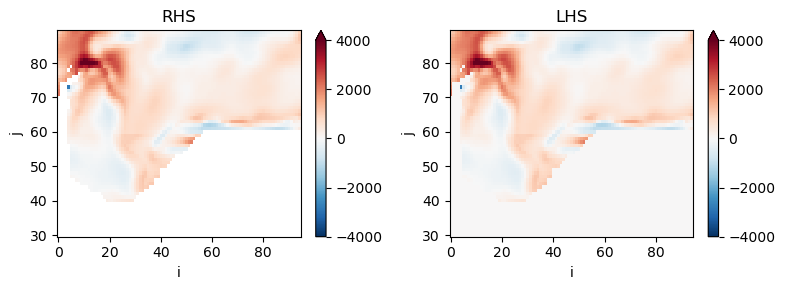

In [20]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check[1, 0].drop('i').plot(ax=ax0, robust=True, vmax=4e3)
ax0.set_title('RHS')

(ds.total_tendency_TH_truth + ds.total_tendency_SLT_truth)[1, 0].drop('i').plot(ax=ax1, robust=True, vmax=4e3)
ax1.set_title('LHS')
plt.tight_layout();

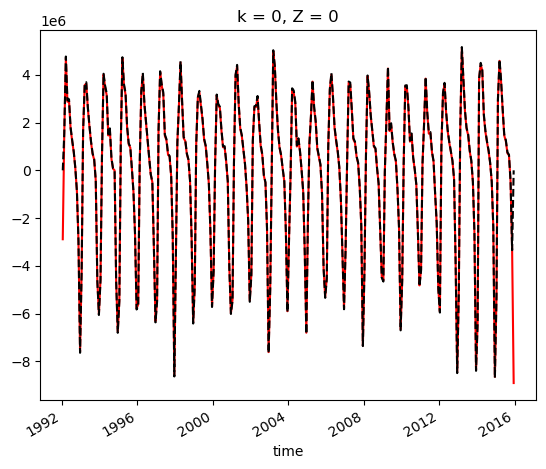

In [21]:
total_tendency_check.isel(k=0).sum(['i', 'j']).plot(color='r')
(ds.total_tendency_TH_truth + ds.total_tendency_SLT_truth).isel(k=0).sum(['i', 'j']).plot(color='k', linestyle='--');

# <font color='Green'>\begin{equation*} \sigma_2\ term \end{equation*} </font>

In [22]:
sigma2 = fastjmd95.rho(ds.SALT, ds.THETA, pref)
sigma2_snp = fastjmd95.rho(ds.SALT_snp, ds.THETA_snp, pref)

In [23]:
sigma2

<xarray.DataArray (time: 288, k: 50, j: 60, i: 95)>
dask.array<transpose, shape=(288, 50, 60, 95), dtype=float64, chunksize=(1, 50, 60, 67), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    XC       (i) int64 dask.array<chunksize=(95,), meta=np.ndarray>
    YC       (j) int64 dask.array<chunksize=(60,), meta=np.ndarray>
    Z        (k) int64 dask.array<chunksize=(50,), meta=np.ndarray>

In [24]:
sigma2_snp

<xarray.DataArray (time_snp: 287, k: 50, j: 60, i: 95)>
dask.array<transpose, shape=(287, 50, 60, 95), dtype=float64, chunksize=(1, 50, 60, 67), chunktype=numpy.ndarray>
Coordinates:
  * i         (i) int64 153 154 155 156 157 158 ... -117 -116 -115 -114 -113
  * j         (j) int64 30 31 32 33 34 35 36 37 38 ... 82 83 84 85 86 87 88 89
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    XC        (i) int64 dask.array<chunksize=(95,), meta=np.ndarray>
    YC        (j) int64 dask.array<chunksize=(60,), meta=np.ndarray>
    Z         (k) int64 dask.array<chunksize=(50,), meta=np.ndarray>
  * time_snp  (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01

In [25]:
sigma2.nbytes/1e9

0.65664

In [26]:
sigma2_snp.nbytes/1e9

0.65436

### Volume-weighted $\frac{\partial{\sigma_2}}{\partial t} =$ _tottend_truth_

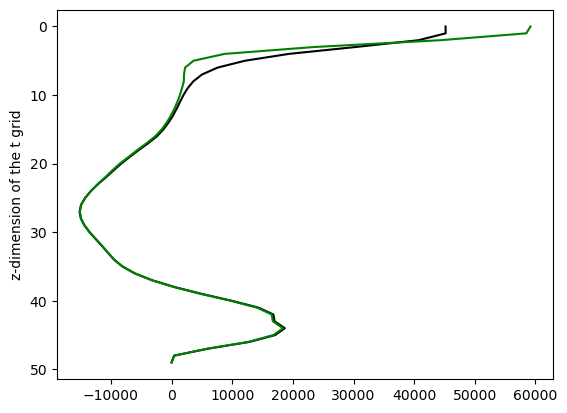

In [27]:
delta_sigma = sigma2_snp.isel(time_snp=-1) - sigma2_snp.isel(time_snp=0)
total_time = (sigma2_snp.time_snp[-1] - sigma2_snp.time_snp[0]).astype('f8')*1e-9
vol = (coords.drF * coords.rA * coords.hFacC)

((delta_sigma * vol).sum(dim=['j', 'i'])/ total_time).plot(y='k', yincrease=False, color='k')
(ds.total_tendency_SLT_truth + ds.total_tendency_TH_truth).sum(dim=['j', 'i']).mean(dim='time').plot(y='k', yincrease=False, 
                                                                                                     color='green')

In [28]:
totend_truth = (delta_sigma * vol) / total_time

In [29]:
dsig_dt = (sigma2.diff(dim='time')*vol)/coords.dt[1:]

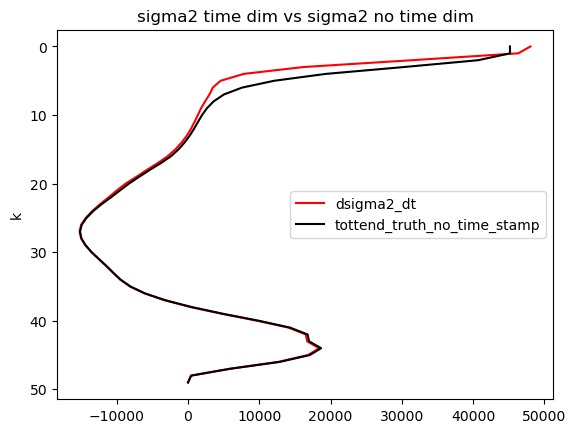

In [75]:
dsig_dt.sum(dim=['j', 'i']).mean(dim='time').plot(y='k', yincrease=False, color='red', label='dsigma2_dt')
totend_truth.sum(dim=['j', 'i']).plot(y='k', yincrease=False, color='k', label='tottend_truth_no_time_stamp')

plt.title('sigma2 time dim vs sigma2 no time dim')
plt.legend();

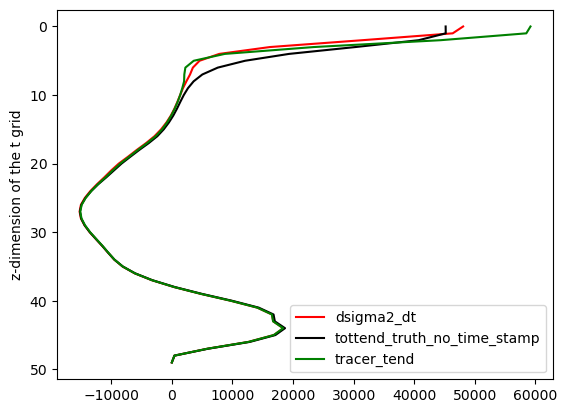

In [76]:
dsig_dt.sum(dim=['j', 'i']).mean(dim='time').plot(y='k', yincrease=False, color='red', label='dsigma2_dt')
totend_truth.sum(dim=['j', 'i']).plot(y='k', yincrease=False, color='k', label='tottend_truth_no_time_stamp')
(ds.total_tendency_SLT_truth + ds.total_tendency_TH_truth).sum(dim=['j', 'i']).mean(dim='time').plot(y='k', yincrease=False, 
                                                                                                     color='green', 
                                                                                                     label='tracer_tend')
plt.legend();

In [30]:
totend_truth = (sigma2.diff(dim='time') * vol) / coords.dt[1:]

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-\sigma-truth} + R1 \end{equation*} </font>

In [31]:
delta_sigma = 0.01
sigma_bins = np.arange(1027.5, 1037.5, delta_sigma)

In [32]:
sigma_bins.size

1000

In [33]:
vol = vol.chunk({'i':-1, 'j':-1, 'k':-1})
sigma2 = sigma2.chunk({'i':-1, 'j':-1, 'k':-1, 'time':1})
sigma2_snp = sigma2_snp.chunk({'i':-1, 'j':-1, 'k':-1, 'time_snp':1})
ds = ds.chunk({'i':-1, 'j':-1, 'k':-1, 'i_g':-1, 'j_g':-1, 'time':1})
ds_sig_salt = ds_sig_salt.chunk({'i':-1, 'j':-1, 'k':-1, 'time':1})
ds_sig_theta = ds_sig_theta.chunk({'i':-1, 'j':-1, 'k':-1, 'time':1})

In [34]:
#load in autoreload so you don't have to restart kernel everytime you want to run bb function
%load_ext autoreload

#Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [35]:
import bb

In [19]:
box1 = box_budget(12, 94, 50, 59)
box2 = box_budget(9, 94, 47, 50)
box3 = box_budget(8, 94, 45, 47)
box4 = box_budget(2, 94, 41, 45)
box5 = box_budget(0, 94, 0, 41)

residual = box1 + box2 + box3 + box4
(residual / 1e6)

-0.095004375

In [36]:
#sigma2 and vol boxes

box1_sigma2_snp = bb.slice_box(sigma2_snp, 12, 94, 50, 59, cell='c')
box2_sigma2_snp = bb.slice_box(sigma2_snp, 9, 94, 47, 50, cell='c')
box3_sigma2_snp = bb.slice_box(sigma2_snp, 8, 94, 45, 47, cell='c')
box4_sigma2_snp = bb.slice_box(sigma2_snp, 2, 94, 41, 45, cell='c')
box5_sigma2_snp = bb.slice_box(sigma2_snp, 0, 94, 0, 41, cell='c')

box1_sigma2 = bb.slice_box(sigma2, 12, 94, 50, 59, cell='c')
box2_sigma2 = bb.slice_box(sigma2, 9, 94, 47, 50, cell='c')
box3_sigma2 = bb.slice_box(sigma2, 8, 94, 45, 47, cell='c')
box4_sigma2 = bb.slice_box(sigma2, 2, 94, 41, 45, cell='c')
box5_sigma2 = bb.slice_box(sigma2, 0, 94, 0, 41, cell='c')

box1_vol = bb.slice_box(vol, 12, 94, 50, 59, cell='c')
box2_vol = bb.slice_box(vol, 9, 94, 47, 50, cell='c')
box3_vol = bb.slice_box(vol, 8, 94, 45, 47, cell='c')
box4_vol = bb.slice_box(vol, 2, 94, 41, 45, cell='c')
box5_vol = bb.slice_box(vol, 0, 94, 0, 41, cell='c')

In [37]:
#sigma_dist boxes

sigma_dist1 = histogram(box1_sigma2_snp.rename('sigma2'), bins=[sigma_bins],
                       weights=box1_vol, dim=['i', 'j', 'k']).load()

sigma_dist2 = histogram(box2_sigma2_snp.rename('sigma2'), bins=[sigma_bins],
                       weights=box2_vol, dim=['i', 'j', 'k']).load()

sigma_dist3 = histogram(box3_sigma2_snp.rename('sigma2'), bins=[sigma_bins],
                       weights=box3_vol, dim=['i', 'j', 'k']).load()

sigma_dist4 = histogram(box4_sigma2_snp.rename('sigma2'), bins=[sigma_bins],
                       weights=box4_vol, dim=['i', 'j', 'k']).load()

sigma_dist5 = histogram(box5_sigma2_snp.rename('sigma2'), bins=[sigma_bins],
                       weights=box5_vol, dim=['i', 'j', 'k']).load()

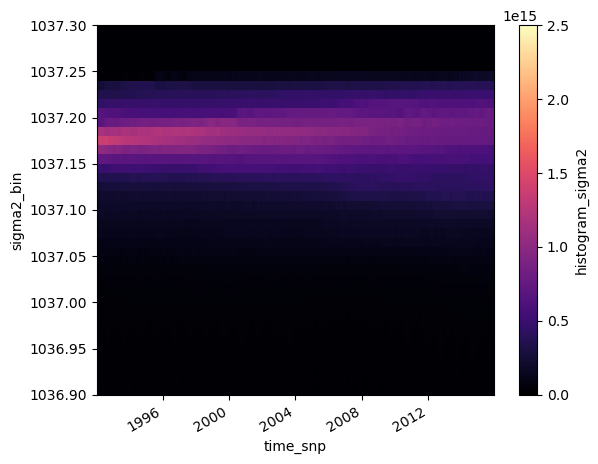

In [38]:
sigma_dist1.plot(x='time_snp', vmax=2.5e15, cmap='magma')
plt.ylim(1036.9, 1037.3);

In [39]:
sigma_dist = sigma_dist1 + sigma_dist2 + sigma_dist3 + sigma_dist4 + sigma_dist5

(1036.8, 1037.4)

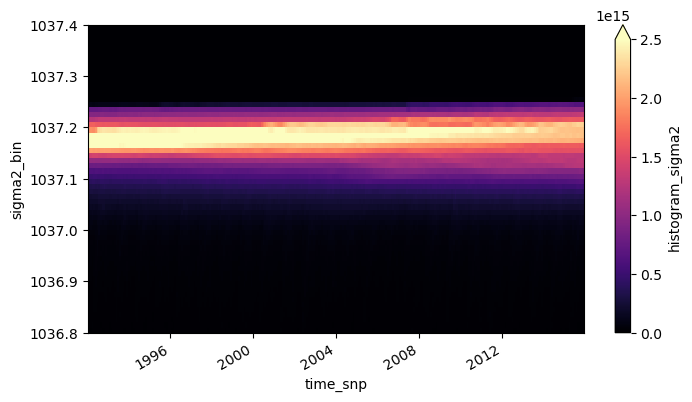

In [40]:
sigma_dist.plot(x='time_snp', figsize=(8, 4), vmax=2.5e15, cmap='magma')
plt.ylim(1036.8, 1037.4)

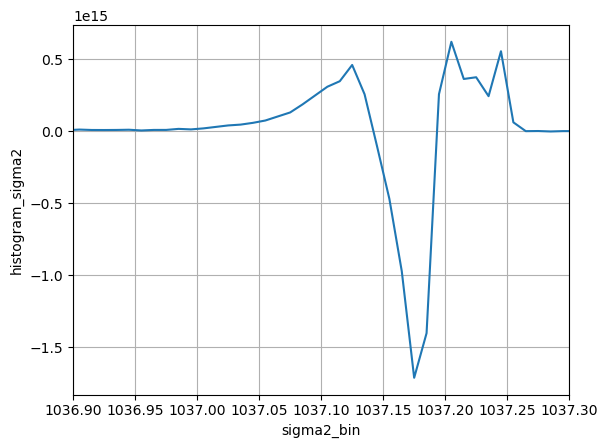

In [41]:
(sigma_dist[-1] - sigma_dist[0]).plot()
plt.xlim(1036.9, 1037.3)
plt.grid();

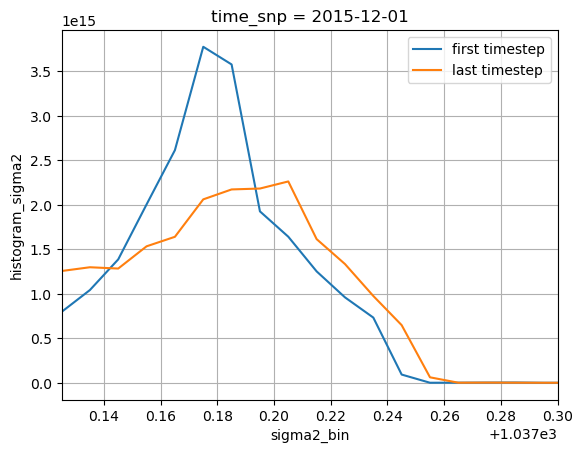

In [42]:
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037.125, 1037.3)
plt.grid();

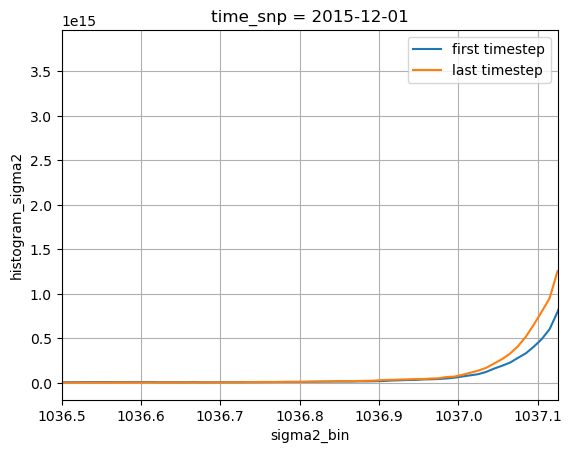

In [43]:
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.5, 1037.125)
plt.grid();

(1037.27, 1036.9)

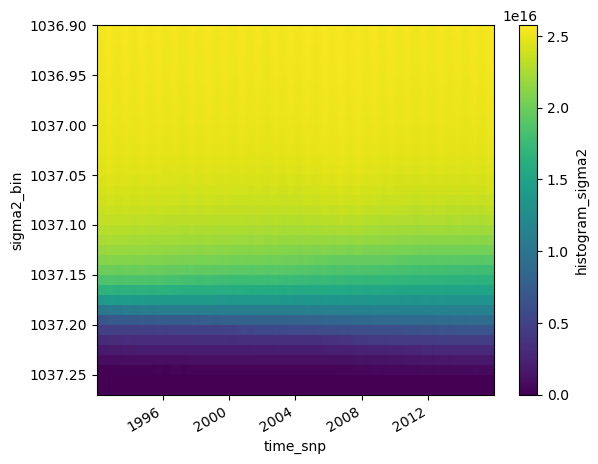

In [44]:
# cumulative volume
V = sigma_dist.isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
V.transpose().plot()
plt.ylim(1037.27, 1036.9)

(1037.125, 1037.3)

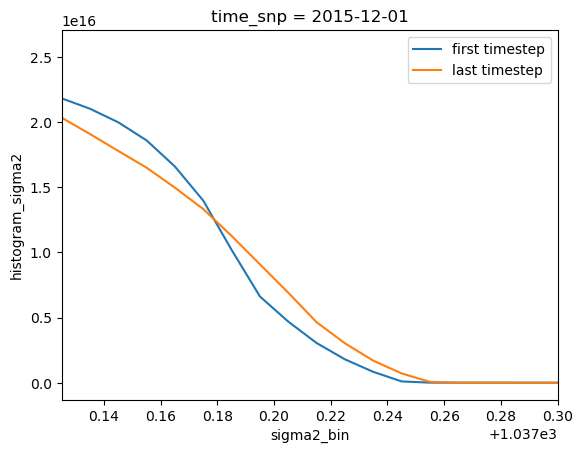

In [45]:
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037.125, 1037.3)

(1036.5, 1037.125)

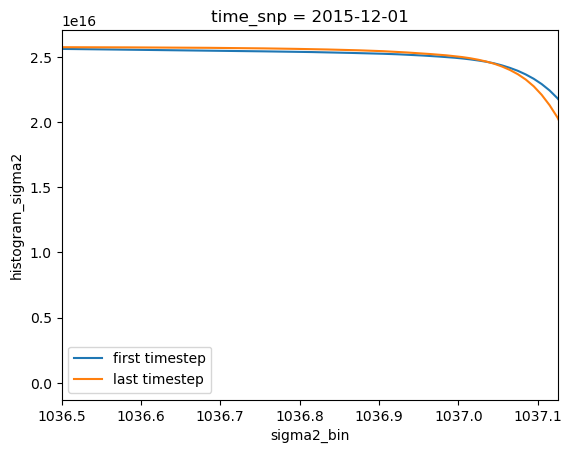

In [46]:
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.5, 1037.125)

(1037.27, 1036.9)

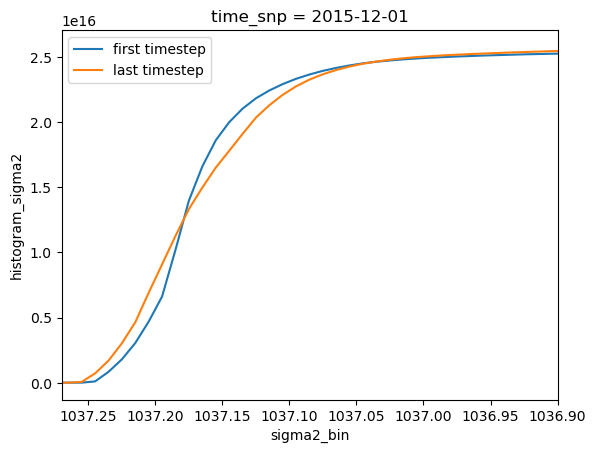

In [47]:
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037.27, 1036.9)

In [48]:
delta_V = V.diff(dim='time_snp')
delta_V.coords['time'] = 'time_snp', ds_tns.time[1:-1].values

In [49]:
delta_V

<xarray.DataArray 'histogram_sigma2' (time_snp: 286, sigma2_bin: 999)>
array([[ 0.0000000e+00, -3.4496011e+11,  0.0000000e+00, ...,
        -1.9327353e+10, -1.9327353e+10, -1.9327353e+10],
       [ 0.0000000e+00, -4.9544323e+10,  0.0000000e+00, ...,
         1.0737418e+10,  1.0737418e+10,  1.0737418e+10],
       [ 0.0000000e+00, -6.0026757e+10,  0.0000000e+00, ...,
        -1.9327353e+10, -1.9327353e+10, -1.9327353e+10],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -8.5899346e+09, -8.5899346e+09, -8.5899346e+09],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         2.1474836e+09,  2.1474836e+09,  2.1474836e+09],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         6.4424509e+09,  6.4424509e+09,  6.4424509e+09]], dtype=float32)
Coordinates:
  * time_snp    (time_snp) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03
    time        (time_snp) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

## $\frac{\partial \mathcal{V}}{\partial t}$

In [50]:
dVdt = delta_V.swap_dims({'time_snp': 'time'}) / coords.dt[1:-1]

In [51]:
dVdt

<xarray.DataArray (time: 286, sigma2_bin: 999)>
dask.array<divide, shape=(286, 999), dtype=float32, chunksize=(286, 999), chunktype=numpy.ndarray>
Coordinates:
    time_snp    (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

(1036.9, 1037.27)

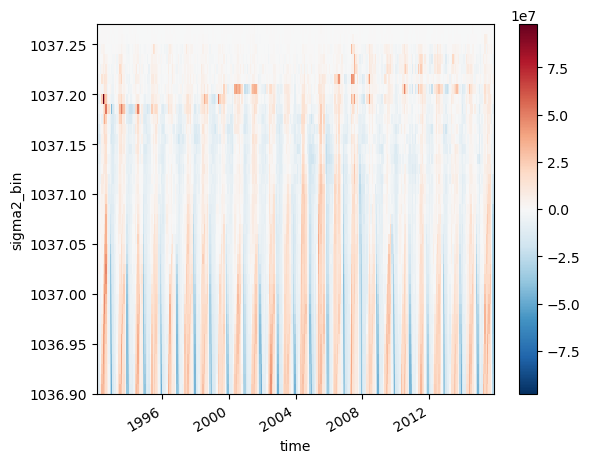

In [52]:
dVdt.plot(x='time')
plt.ylim(1036.9, 1037.27)

## $\Omega_{total}$

In [53]:
#total tendency th - weights for omega total th

tot_th1 = bb.slice_box(ds.total_tendency_TH_truth, 12, 94, 50, 59, cell='c')
tot_th2 = bb.slice_box(ds.total_tendency_TH_truth, 9, 94, 47, 50, cell='c')
tot_th3 = bb.slice_box(ds.total_tendency_TH_truth, 8, 94, 45, 47, cell='c')
tot_th4 = bb.slice_box(ds.total_tendency_TH_truth, 2, 94, 41, 45, cell='c')
tot_th5 = bb.slice_box(ds.total_tendency_TH_truth, 0, 94, 0, 41, cell='c')

#total tendency slt - weights for omega total slt

tot_slt1 = bb.slice_box(ds.total_tendency_SLT_truth, 12, 94, 50, 59, cell='c')
tot_slt2 = bb.slice_box(ds.total_tendency_SLT_truth, 9, 94, 47, 50, cell='c')
tot_slt3 = bb.slice_box(ds.total_tendency_SLT_truth, 8, 94, 45, 47, cell='c')
tot_slt4 = bb.slice_box(ds.total_tendency_SLT_truth, 2, 94, 41, 45, cell='c')
tot_slt5 = bb.slice_box(ds.total_tendency_SLT_truth, 0, 94, 0, 41, cell='c')

In [54]:
#omega total boxes

#omega_th
omega_tot_th1 = (histogram(box1_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=tot_th1.fillna(0.), dim=['i', 'j', 'k']) / delta_sigma).load()
omega_tot_th2 = (histogram(box2_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=tot_th2.fillna(0.), dim=['i', 'j', 'k']) / delta_sigma).load()
omega_tot_th3 = (histogram(box3_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=tot_th3.fillna(0.), dim=['i', 'j', 'k']) / delta_sigma).load()
omega_tot_th4 = (histogram(box4_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=tot_th4.fillna(0.), dim=['i', 'j', 'k']) / delta_sigma).load()
omega_tot_th5 = (histogram(box5_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=tot_th5.fillna(0.), dim=['i', 'j', 'k']) / delta_sigma).load()

#omega_slt
omega_tot_slt1 = (histogram(box1_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=tot_slt1.fillna(0.), dim=['i', 'j', 'k']) / delta_sigma).load()
omega_tot_slt2 = (histogram(box2_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=tot_slt2.fillna(0.), dim=['i', 'j', 'k']) / delta_sigma).load()
omega_tot_slt3 = (histogram(box3_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=tot_slt3.fillna(0.), dim=['i', 'j', 'k']) / delta_sigma).load()
omega_tot_slt4 = (histogram(box4_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=tot_slt4.fillna(0.), dim=['i', 'j', 'k']) / delta_sigma).load()
omega_tot_slt5 = (histogram(box5_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=tot_slt5.fillna(0.), dim=['i', 'j', 'k']) / delta_sigma).load()

omega_total_th = (omega_tot_th1 + omega_tot_th2 + omega_tot_th3 + omega_tot_th4 + omega_tot_th5)
omega_total_slt = (omega_tot_slt1 + omega_tot_slt2 + omega_tot_slt3 + omega_tot_slt4 + omega_tot_slt5)
omega_total = (omega_total_th + omega_total_slt)

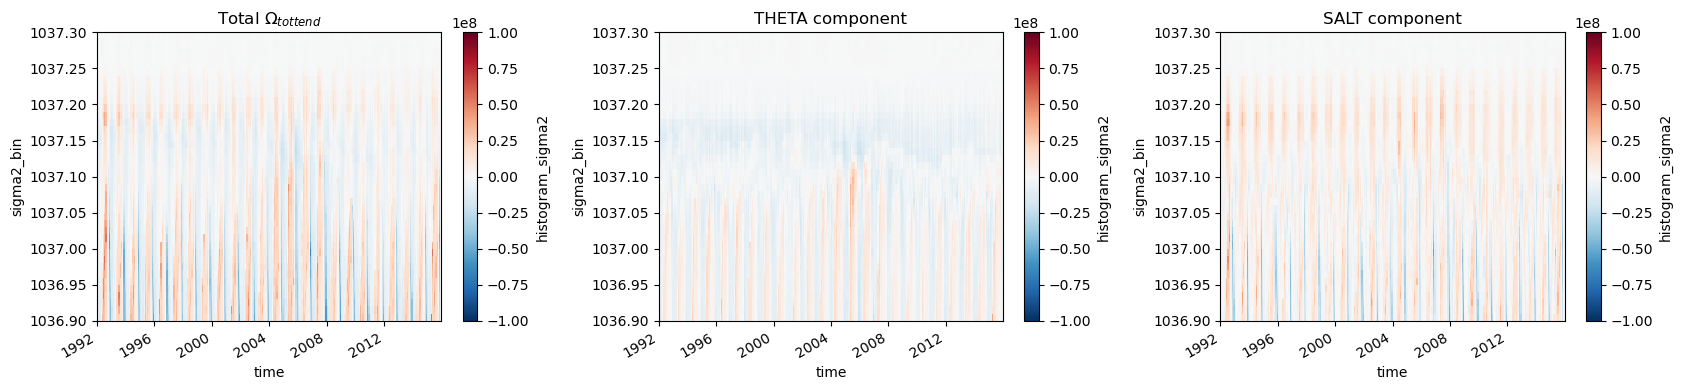

In [55]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

omega_total.plot(x='time', vmax=1e8, ax=ax0, yincrease=False)
ax0.set_ylim(ymin=1036.9, ymax=1037.3)
ax0.set_title(r'Total $\Omega_{tottend}$')

omega_total_th.plot(x='time', vmax=1e8, ax=ax1, yincrease=False)
ax1.set_ylim(ymin=1036.9, ymax=1037.3)
ax1.set_title('THETA component')

omega_total_slt.plot(x='time', vmax=1e8, ax=ax2, yincrease=False)
ax2.set_ylim(ymin=1036.9, ymax=1037.3)
ax2.set_title('SALT component')

plt.tight_layout();

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of sigma layers) </font>

In [56]:
dVdt.coords

Coordinates:
    time_snp    (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [58]:
omega_total[1:-1].coords

Coordinates:
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

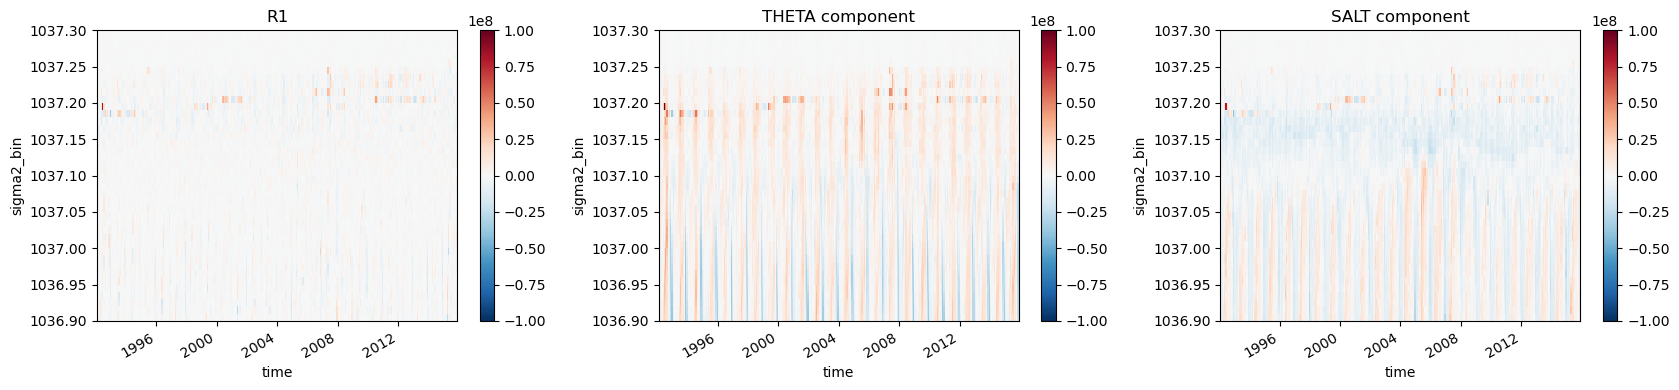

In [59]:
R1 = dVdt - omega_total[1:-1]
R1_th = dVdt - omega_total_th[1:-1]
R1_slt = dVdt - omega_total_slt[1:-1]

fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

R1.plot(x='time', vmax=1e8, ax=ax0)
ax0.set_ylim(ymin=1036.9,ymax=1037.3)
ax0.set_title('R1')

R1_th.plot(x='time', vmax=1e8, ax=ax1)
ax1.set_ylim(ymin=1036.9, ymax=1037.3)
ax1.set_title('THETA component')

R1_slt.plot(x='time', vmax=1e8, ax=ax2)
ax2.set_ylim(ymin=1036.9, ymax=1037.3)
ax2.set_title('SALT component')

plt.tight_layout();

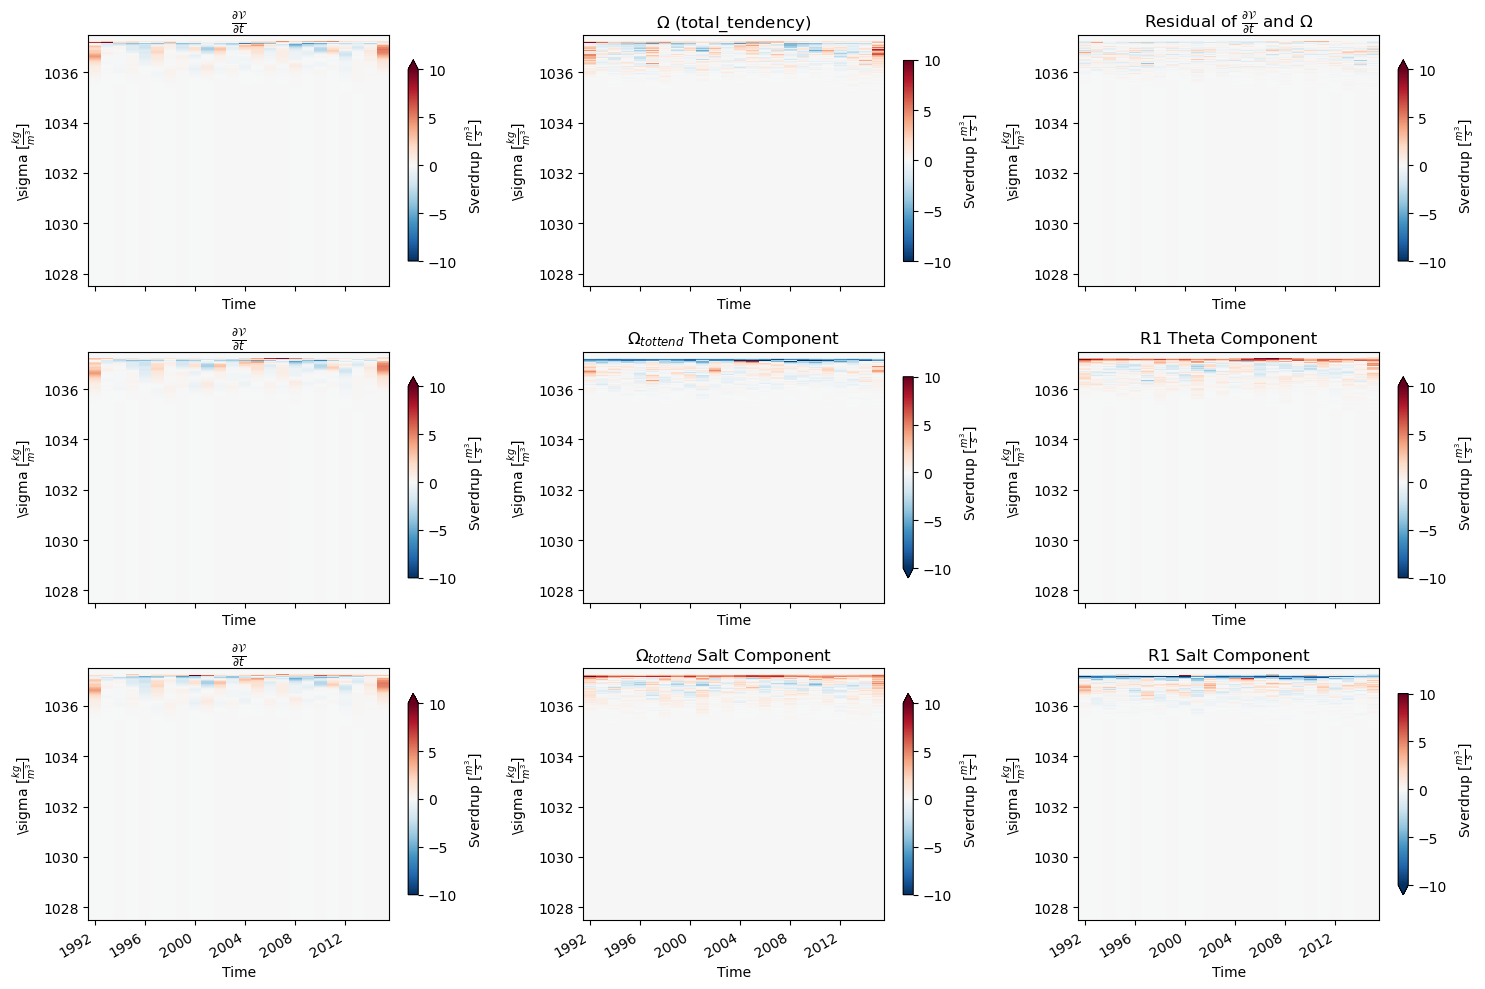

In [60]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,0], vmax=10,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')#, fontsize=14)
axes[0,0].set_xlabel('Time')#, fontsize=14)
axes[0,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')#, fontsize=24)
#axes[0,0].set_ylim(1036.4, 1037.3)

(omega_total[1:-1]/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,1], vmax=10,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,1].set_xlabel('Time')#, fontsize=14)
axes[0,1].set_title('$\Omega$ (total_tendency)')
#axes[0,1].set_ylim(1036.4, 1037.3)

(R1/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,2], vmax=10,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,2].set_xlabel('Time')
axes[0,2].set_title(r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$')
#axes[0,2].set_ylim(1036.4, 1037.3)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,0], vmax=10,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,0].set_xlabel('Time')
axes[1,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')
#axes[1,0].set_ylim(1036.4, 1037.3)

(omega_total_th[1:-1]/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,1], vmax=10,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,1].set_xlabel('Time')
axes[1,1].set_title(r'$\Omega_{tottend}$ Theta Component')
#axes[1,1].set_ylim(1036.4, 1037.3)

(R1_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,2], vmax=10,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,2].set_xlabel('Time')#, fontsize=14)
axes[1,2].set_title(r'R1 Theta Component')
#axes[1,2].set_ylim(1036.4, 1037.3)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,0], vmax=10,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,0].set_xlabel('Time')
axes[2,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')
#axes[2,0].set_ylim(1036.4, 1037.3)

(omega_total_slt[1:-1]/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,1], vmax=10,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,1].set_xlabel('Time')
axes[2,1].set_title(r'$\Omega_{tottend}$ Salt Component')
#axes[2,1].set_ylim(1036.4, 1037.3)

(R1_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,2], vmax=10,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,2].set_xlabel('Time')#, fontsize=14)
axes[2,2].set_title(r'R1 Salt Component')
#axes[2,2].set_ylim(1036.4, 1037.3)

plt.tight_layout();

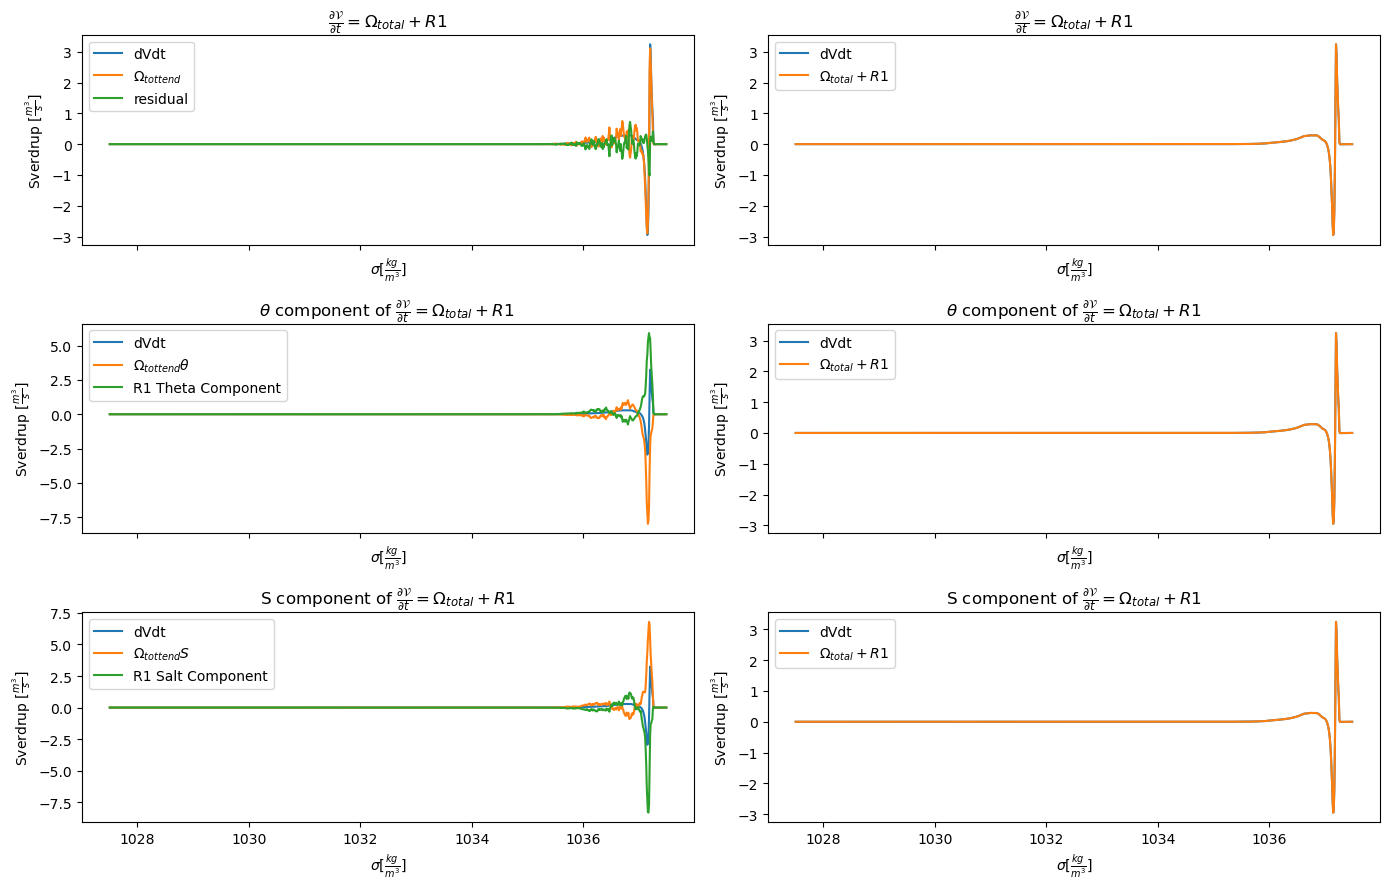

In [61]:
fig, axes = plt.subplots(3, 2, figsize=(14, 9), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[0,0])
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[0,0])
(R1/1e6).mean(dim='time').plot(label='residual', ax=axes[0,0])
axes[0,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,0].legend()
axes[0,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
#axes[0,0].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[0,1])
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[0,1])
axes[0,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,1].legend()
axes[0,1].set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
#axes[0,1].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[1,0])
(omega_total_th/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} \theta$', ax=axes[1,0])
(R1_th/1e6).mean(dim='time').plot(label='R1 Theta Component', ax=axes[1,0])
axes[1,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,0].legend()
axes[1,0].set_title(r'$\theta$ component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$ ')
#axes[1,0].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[1,1])
((omega_total_th + R1_th)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[1,1])
axes[1,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,1].legend()
axes[1,1].set_title(r'$\theta$ component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
#axes[1,1].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[2,0])
(omega_total_slt/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} S$', ax=axes[2,0])
(R1_slt/1e6).mean(dim='time').plot(label='R1 Salt Component', ax=axes[2,0])
axes[2,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,0].legend()
axes[2,0].set_title(r'S component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
#axes[2,0].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[2,1])
((omega_total_slt + R1_slt)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[2,1])
axes[2,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,1].legend()
axes[2,1].set_title(r'S component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
#axes[2,1].set_xlim(1036.4, 1037.3)

plt.tight_layout();

## <span style='color:Green'> \begin{equation*} \Omega_{transformation-rate} \end{equation*}

In [62]:
def histogram_func(weight):
    """Generalized xhistogram's histogram function 
    for adv and diff flux terms"""

    #weights section
    box1_weight = bb.slice_box(weight, 12, 94, 50, 59, cell='c')
    box2_weight = bb.slice_box(weight, 9, 94, 47, 50, cell='c')
    box3_weight = bb.slice_box(weight, 8, 94, 45, 47, cell='c')
    box4_weight = bb.slice_box(weight, 2, 94, 41, 45, cell='c')
    box5_weight = bb.slice_box(weight, 0, 94, 0, 41, cell='c')

    #histogram section
    hist1 = histogram(box1_sigma2.rename('sigma2'), bins=[sigma_bins],
                     weights=box1_weight.fillna(0.), dim=['i', 'j', 'k']) / delta_sigma
    hist2 = histogram(box2_sigma2.rename('sigma2'), bins=[sigma_bins],
                     weights=box2_weight.fillna(0.), dim=['i', 'j', 'k']) / delta_sigma
    hist3 = histogram(box3_sigma2.rename('sigma2'), bins=[sigma_bins],
                     weights=box3_weight.fillna(0.), dim=['i', 'j', 'k']) / delta_sigma
    hist4 = histogram(box4_sigma2.rename('sigma2'), bins=[sigma_bins],
                     weights=box4_weight.fillna(0.), dim=['i', 'j', 'k']) / delta_sigma
    hist5 = histogram(box5_sigma2.rename('sigma2'), bins=[sigma_bins],
                     weights=box5_weight.fillna(0.), dim=['i', 'j', 'k']) / delta_sigma
    
    hist = hist1 + hist2 + hist3 + hist4 + hist5
    
    return hist 

In [63]:
all_tendencies_th = list(ds_sig_theta)
all_tendencies_slt = list(ds_sig_salt)

In [64]:
all_dsets_th = xr.merge([histogram_func(ds_sig_theta[var]).rename('OMEGA_' + var)
                      for var in all_tendencies_th])
all_dsets_slt = xr.merge([histogram_func(ds_sig_salt[var]).rename('OMEGA_' + var)
                      for var in all_tendencies_slt])

In [65]:
all_dsets = xr.merge([all_dsets_th, all_dsets_slt])

In [66]:
all_dsets

<xarray.Dataset>
Dimensions:                         (time: 288, sigma2_bin: 999)
Coordinates:
  * time                            (time) datetime64[ns] 1992-01-15 ... 2015...
  * sigma2_bin                      (sigma2_bin) float64 1.028e+03 ... 1.037e+03
Data variables:
    OMEGA_conv_horiz_adv_flux_TH    (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_conv_horiz_diff_flux_TH   (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_conv_vert_adv_flux_TH     (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_conv_vert_diff_flux_TH    (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_surface_flux_conv_TH      (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_sw_flux_conv_TH           (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_total_tendency_TH_truth   (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_conv_adv_flux_SLT         (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_conv_diff_flux_SLT        (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_surface_flux_SLT          (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_total_tendency_SLT_truth  (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>

In [67]:
client.restart()

<Client: 'tls://10.1.39.3:8786' processes=21 threads=42, memory=630.00 GiB>

In [68]:
omega_trans_rate_th = (all_dsets_th.OMEGA_conv_horiz_diff_flux_TH + 
                        all_dsets_th.OMEGA_conv_vert_diff_flux_TH +
                        all_dsets_th.OMEGA_sw_flux_conv_TH + 
                        all_dsets_th.OMEGA_surface_flux_conv_TH)
omega_trans_rate_th.load()

<xarray.DataArray (time: 288, sigma2_bin: 999)>
array([[    0.        ,     0.        ,     0.        , ...,
            0.        , -1906.95280941,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
        -1050.95437562,  -895.99043064,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
        -1655.99623357,  -325.79302696,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [69]:
all_dsets_slt

<xarray.Dataset>
Dimensions:                         (time: 288, sigma2_bin: 999)
Coordinates:
  * time                            (time) datetime64[ns] 1992-01-15 ... 2015...
  * sigma2_bin                      (sigma2_bin) float64 1.028e+03 ... 1.037e+03
Data variables:
    OMEGA_conv_adv_flux_SLT         (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_conv_diff_flux_SLT        (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_surface_flux_SLT          (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_total_tendency_SLT_truth  (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>

In [70]:
omega_trans_rate_slt = (all_dsets_slt.OMEGA_conv_diff_flux_SLT + 
                          all_dsets_slt.OMEGA_surface_flux_SLT)
omega_trans_rate_slt.load()

omega_trans_rate = omega_trans_rate_th + omega_trans_rate_slt
omega_trans_rate.load()

<xarray.DataArray (time: 288, sigma2_bin: 999)>
array([[    0.        ,     0.        ,     0.        , ...,
            0.        , -7065.50729217,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
        -3358.78694195, -3734.77088159,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
        -5737.80932392, -1369.1330103 ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [71]:
test_omega = omega_trans_rate.isel(sigma2_bin=-1) - omega_trans_rate.sel(sigma2_bin=1037.155, method='nearest')
test_omega_slt = omega_trans_rate_slt.isel(sigma2_bin=-1) - omega_trans_rate_slt.sel(sigma2_bin=1037.155, method='nearest')
test_omega_th = omega_trans_rate_th.isel(sigma2_bin=-1) - omega_trans_rate_th.sel(sigma2_bin=1037.155, method='nearest')

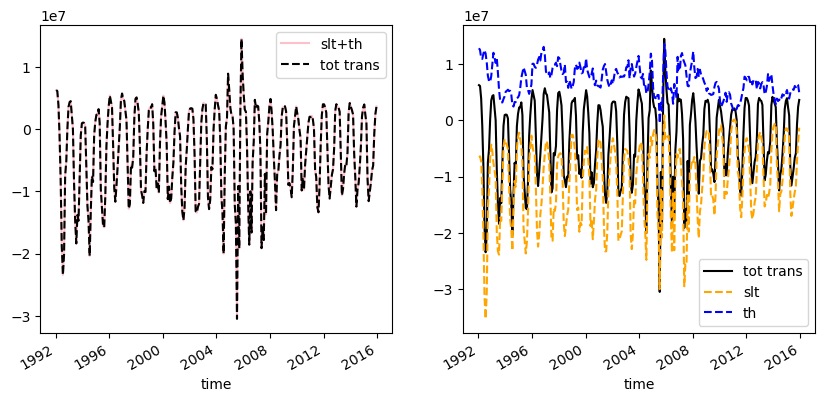

In [72]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

(test_omega_slt+test_omega_th).plot(label='slt+th', ax=ax0, color='pink')
test_omega.plot(label='tot trans', ax=ax0, linestyle='--', color='k')
ax0.legend()

test_omega.plot(label='tot trans', color='k', ax=ax1)
test_omega_slt.plot(label='slt', color='orange', linestyle='--', ax=ax1)
test_omega_th.plot(label='th', color='blue', linestyle='--', ax=ax1)
ax1.legend();

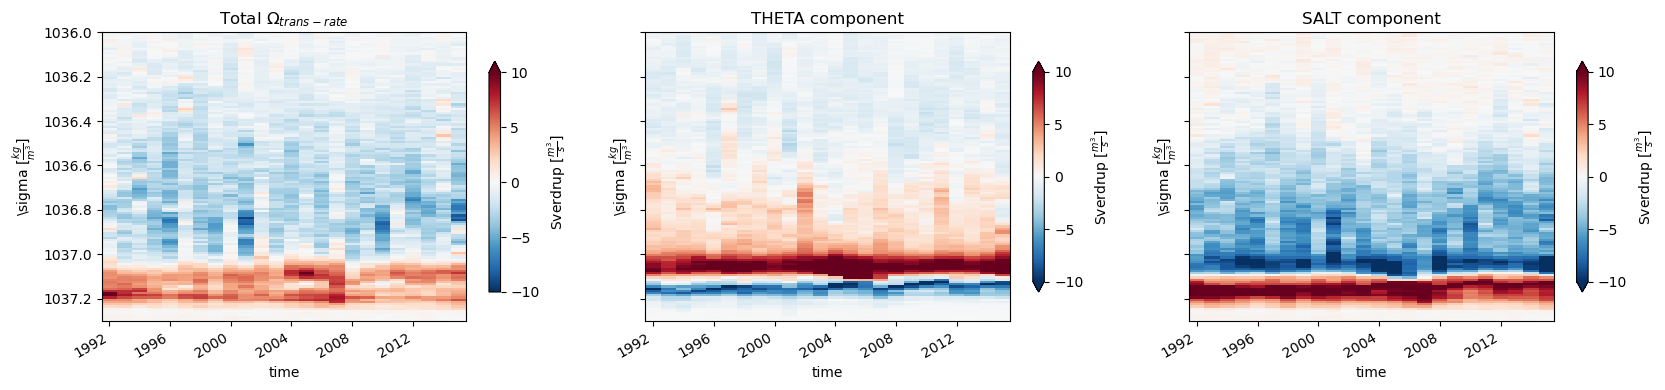

In [73]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4), sharey=True)

(omega_trans_rate.resample(time='AS').mean()/1e6).plot(x='time', ax=ax0, vmax=10, yincrease=False,
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
#ax0.set_ylim(1037.5, 1036)
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax0.set_title(r'Total $\Omega_{trans-rate}$')

(omega_trans_rate_th.resample(time='AS').mean()/1e6).plot(x='time', ax=ax1, vmax=10, yincrease=False,
                                                          cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
#ax1.set_ylim(1037.5, 1036)
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_title('THETA component')

(omega_trans_rate_slt.resample(time='AS').mean()/1e6).plot(x='time', ax=ax2, vmax=10, yincrease=False,
                                                           cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylim(1037.3, 1036)
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_title('SALT component')

plt.tight_layout();

## Transformation maps sect begin

## <font color='Green'> \begin{equation*} \Psi_{adv} = \Psi_{vel} + R2 \end{equation*} (Numerical Mixing) </font>

## $\Psi_{adv}$

In [74]:
psi_adv_th = (all_dsets_th.OMEGA_conv_horiz_adv_flux_TH + all_dsets_th.OMEGA_conv_vert_adv_flux_TH)
psi_adv_th.load()

<xarray.DataArray (time: 288, sigma2_bin: 999)>
array([[   0.        ,    0.        ,    0.        , ...,    0.        ,
         111.08604594,    0.        ],
       [   0.        ,    0.        ,    0.        , ..., -718.700024  ,
         464.22012245,    0.        ],
       [   0.        ,    0.        ,    0.        , ..., -224.77717275,
         498.48979605,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [75]:
psi_adv_slt = (all_dsets_slt.OMEGA_conv_adv_flux_SLT)
psi_adv_slt.load()

<xarray.DataArray 'OMEGA_conv_adv_flux_SLT' (time: 288, sigma2_bin: 999)>
array([[    0.        ,     0.        ,     0.        , ...,
            0.        , -1109.86345147,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
        -2277.11257002,  1112.43419104,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
        -2480.19184441,   976.61871145,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [76]:
psi_adv = psi_adv_th + psi_adv_slt
psi_adv.load()

<xarray.DataArray (time: 288, sigma2_bin: 999)>
array([[    0.        ,     0.        ,     0.        , ...,
            0.        ,  -998.77740553,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
        -2995.81259402,  1576.65431348,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
        -2704.96901716,  1475.1085075 ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

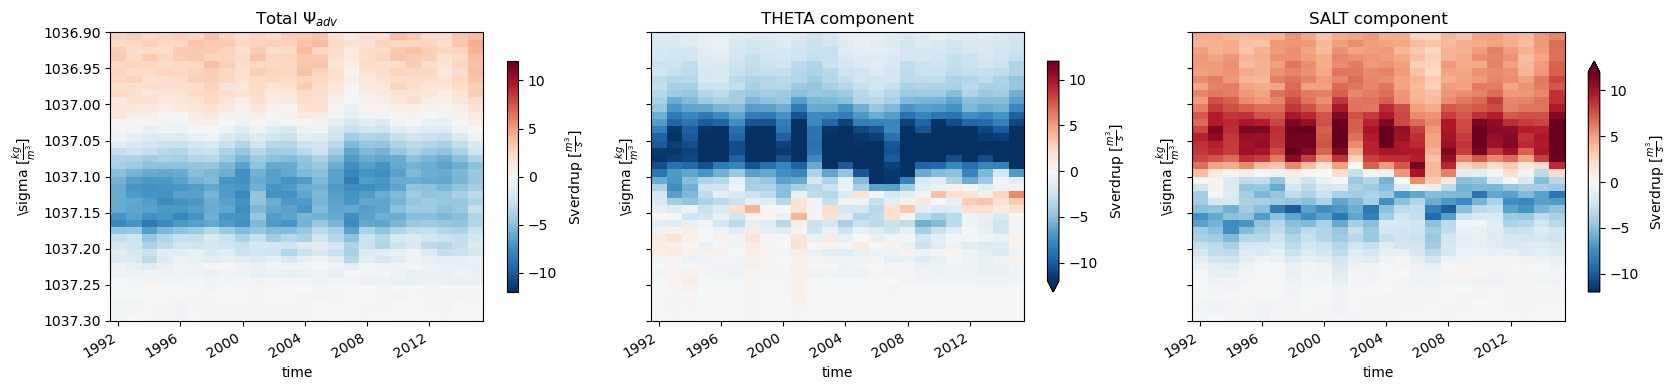

In [77]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, sharey=True, figsize=(17,4))

(psi_adv.resample(time='AS').mean()/1e6).plot(x='time', ax=ax0, vmax=12, yincrease=False,
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylim(1037.3, 1036.9)
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax0.set_title(r'Total $\Psi_{adv}$')

(psi_adv_th.resample(time='AS').mean()/1e6).plot(x='time', ax=ax1, vmax=12, yincrease=False,
                                                          cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylim(1037.3, 1036.9)
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_title('THETA component')

(psi_adv_slt.resample(time='AS').mean()/1e6).plot(x='time', ax=ax2, vmax=12, yincrease=False,
                                                           cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylim(1037.3, 1036.9)
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_title('SALT component')

plt.tight_layout();

## $\Psi_{vel}$

In [78]:
#testing imported bb module

#area-weighting velocities
UVEL = ds.UVELMASS * coords.dyG * coords.drF 
VVEL = ds.VVELMASS * coords.dxG * coords.drF

#testing generalized function for transport

box1 = bb.box_budget(UVEL, VVEL, 12, 94, 50, 59)
box2 = bb.box_budget(UVEL, VVEL, 9, 94, 47, 50)
box3 = bb.box_budget(UVEL, VVEL, 8, 94, 45, 47)
box4 = bb.box_budget(UVEL, VVEL, 2, 94, 41, 45)
box5 = bb.box_budget(UVEL, VVEL, 0, 94, 0, 41)

residual_vel = box1 + box2 + box3 + box4 + box5
(residual_vel.mean('time')/1e6).values

array(-0.07563032, dtype=float32)

In [79]:
#area-weighting velocities
UVEL = ds.UVELMASS * coords.dyG * coords.drF 
VVEL = ds.VVELMASS * coords.dxG * coords.drF
Ubolus = ds.UVELSTAR * coords.dyG * coords.drF
Vbolus = ds.VVELSTAR * coords.dxG * coords.drF

In [80]:
#right
box1_r_transport = bb.box_budget(UVEL, VVEL, 12, 94, 50, 59, bs='right').load()
box2_r_transport = bb.box_budget(UVEL, VVEL, 9, 94, 47, 50, bs='right').load()
box3_r_transport = bb.box_budget(UVEL, VVEL, 8, 94, 45, 47, bs='right').load()
box4_r_transport = bb.box_budget(UVEL, VVEL, 2, 94, 41, 45, bs='right').load()
box5_r_transport = bb.box_budget(UVEL, VVEL, 0, 94, 0, 41, bs='right').load()

u_transport_right = (box1_r_transport.sum(('j', 'k')) + box2_r_transport.sum(('j', 'k')) + 
                     box3_r_transport.sum(('j', 'k')) + box4_r_transport.sum(('j', 'k')) +
                     box5_r_transport.sum(('j', 'k')))
#right - bolus vel
box1_r_bolus = bb.box_budget(Ubolus, Vbolus, 12, 94, 50, 59, bs='right').load()
box2_r_bolus = bb.box_budget(Ubolus, Vbolus, 9, 94, 47, 50, bs='right').load()
box3_r_bolus = bb.box_budget(Ubolus, Vbolus, 8, 94, 45, 47, bs='right').load()
box4_r_bolus = bb.box_budget(Ubolus, Vbolus, 2, 94, 41, 45, bs='right').load()
box5_r_bolus = bb.box_budget(Ubolus, Vbolus, 0, 94, 0, 41, bs='right').load()

u_bolus_transport_right = (box1_r_bolus.sum(('j', 'k')) + box2_r_bolus.sum(('j', 'k')) + 
                             box3_r_bolus.sum(('j', 'k')) + box4_r_bolus.sum(('j', 'k')) +
                             box5_r_bolus.sum(('j', 'k')))

In [81]:
#left
box1_l_transport = bb.box_budget(UVEL, VVEL, 12, 94, 50, 59, bs='left').load()
box2_l_transport = bb.box_budget(UVEL, VVEL, 9, 94, 47, 50, bs='left').load()
box3_l_transport = bb.box_budget(UVEL, VVEL, 8, 94, 45, 47, bs='left').load()
box4_l_transport = bb.box_budget(UVEL, VVEL, 2, 94, 41, 45, bs='left').load()
box5_l_transport = bb.box_budget(UVEL, VVEL, 0, 94, 0, 41, bs='left').load()

u_transport_left = (box1_l_transport.sum(('j', 'k')) + box2_l_transport.sum(('j', 'k')) + 
                     box3_l_transport.sum(('j', 'k')) + box4_l_transport.sum(('j', 'k')) +
                     box5_l_transport.sum(('j', 'k')))
#left - bolus vel
box1_l_bolus = bb.box_budget(Ubolus, Vbolus, 12, 94, 50, 59, bs='left').load()
box2_l_bolus = bb.box_budget(Ubolus, Vbolus, 9, 94, 47, 50, bs='left').load()
box3_l_bolus = bb.box_budget(Ubolus, Vbolus, 8, 94, 45, 47, bs='left').load()
box4_l_bolus = bb.box_budget(Ubolus, Vbolus, 2, 94, 41, 45, bs='left').load()
box5_l_bolus = bb.box_budget(Ubolus, Vbolus, 0, 94, 0, 41, bs='left').load()

u_bolus_transport_left = (box1_l_bolus.sum(('j', 'k')) + box2_l_bolus.sum(('j', 'k')) + 
                             box3_l_bolus.sum(('j', 'k')) + box4_l_bolus.sum(('j', 'k')) +
                             box5_l_bolus.sum(('j', 'k')))

In [82]:
#upper
box1_u_transport = bb.box_budget(UVEL, VVEL, 12, 94, 50, 59, bs='upper').load()
box2_u_transport = bb.box_budget(UVEL, VVEL, 9, 94, 47, 50, bs='upper').load()
box3_u_transport = bb.box_budget(UVEL, VVEL, 8, 94, 45, 47, bs='upper').load()
box4_u_transport = bb.box_budget(UVEL, VVEL, 2, 94, 41, 45, bs='upper').load()
box5_u_transport = bb.box_budget(UVEL, VVEL, 0, 94, 0, 41, bs='upper').load()

v_transport_upper = (box1_u_transport.sum(('i', 'k')) + box2_u_transport.sum(('i', 'k')) + 
                     box3_u_transport.sum(('i', 'k')) + box4_u_transport.sum(('i', 'k')) +
                     box5_u_transport.sum(('i', 'k')))
#left - bolus vel
box1_u_bolus = bb.box_budget(Ubolus, Vbolus, 12, 94, 50, 59, bs='upper').load()
box2_u_bolus = bb.box_budget(Ubolus, Vbolus, 9, 94, 47, 50, bs='upper').load()
box3_u_bolus = bb.box_budget(Ubolus, Vbolus, 8, 94, 45, 47, bs='upper').load()
box4_u_bolus = bb.box_budget(Ubolus, Vbolus, 2, 94, 41, 45, bs='upper').load()
box5_u_bolus = bb.box_budget(Ubolus, Vbolus, 0, 94, 0, 41, bs='upper').load()

v_bolus_transport_upper = (box1_u_bolus.sum(('i', 'k')) + box2_u_bolus.sum(('i', 'k')) + 
                            box3_u_bolus.sum(('i', 'k')) + box4_u_bolus.sum(('i', 'k')) +
                            box5_u_bolus.sum(('i', 'k')))

In [83]:
#lower
box1_lo_transport = bb.box_budget(UVEL, VVEL, 12, 94, 50, 59, bs='lower').load()
box2_lo_transport = bb.box_budget(UVEL, VVEL, 9, 94, 47, 50, bs='lower').load()
box3_lo_transport = bb.box_budget(UVEL, VVEL, 8, 94, 45, 47, bs='lower').load()
box4_lo_transport = bb.box_budget(UVEL, VVEL, 2, 94, 41, 45, bs='lower').load()
box5_lo_transport = bb.box_budget(UVEL, VVEL, 0, 94, 0, 41, bs='lower').load()

v_transport_lower = (box1_lo_transport.sum(('i', 'k')) + box2_lo_transport.sum(('i', 'k')) + 
                     box3_lo_transport.sum(('i', 'k')) + box4_lo_transport.sum(('i', 'k')) +
                     box5_lo_transport.sum(('i', 'k')))
#left - bolus vel
box1_lo_bolus = bb.box_budget(Ubolus, Vbolus, 12, 94, 50, 59, bs='lower').load()
box2_lo_bolus = bb.box_budget(Ubolus, Vbolus, 9, 94, 47, 50, bs='lower').load()
box3_lo_bolus = bb.box_budget(Ubolus, Vbolus, 8, 94, 45, 47, bs='lower').load()
box4_lo_bolus = bb.box_budget(Ubolus, Vbolus, 2, 94, 41, 45, bs='lower').load()
box5_lo_bolus = bb.box_budget(Ubolus, Vbolus, 0, 94, 0, 41, bs='lower').load()

v_bolus_transport_lower = (box1_lo_bolus.sum(('i', 'k')) + box2_lo_bolus.sum(('i', 'k')) + 
                             box3_lo_bolus.sum(('i', 'k')) + box4_lo_bolus.sum(('i', 'k')) +
                             box5_lo_bolus.sum(('i', 'k')))

In [84]:
#same as residual_vel above
#can switch signs of right/left/upper/lower
residual_vel2 = (-u_transport_right - u_bolus_transport_right 
                 + u_transport_left + u_bolus_transport_left 
                 - v_transport_upper - v_bolus_transport_upper 
                 + v_transport_lower + v_bolus_transport_lower)
(residual_vel2.mean('time')/1e6).values

array(-0.07563058)

In [85]:
#right
box1_rhist = histogram(box1_sigma2.isel(i=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box1_r_transport, dim=['k','j'])
box2_rhist = histogram(box2_sigma2.isel(i=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box2_r_transport, dim=['k','j'])
box3_rhist = histogram(box3_sigma2.isel(i=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box3_r_transport, dim=['k','j'])
box4_rhist = histogram(box4_sigma2.isel(i=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box4_r_transport, dim=['k','j'])
box5_rhist = histogram(box5_sigma2.isel(i=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box5_r_transport, dim=['k','j'])
#right - bolus
box1_rhist_bolus = histogram(box1_sigma2.isel(i=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box1_r_bolus, dim=['k','j'])
box2_rhist_bolus = histogram(box2_sigma2.isel(i=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box2_r_bolus, dim=['k','j'])
box3_rhist_bolus = histogram(box3_sigma2.isel(i=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box3_r_bolus, dim=['k','j'])
box4_rhist_bolus = histogram(box4_sigma2.isel(i=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box4_r_bolus, dim=['k','j'])
box5_rhist_bolus = histogram(box5_sigma2.isel(i=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box5_r_bolus, dim=['k','j'])

#left
box1_lhist = histogram(box1_sigma2.isel(i=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box1_l_transport, dim=['k','j'])#.load()
box2_lhist = histogram(box2_sigma2.isel(i=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box2_l_transport, dim=['k','j'])#.load()
box3_lhist = histogram(box3_sigma2.isel(i=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box3_l_transport, dim=['k','j'])#.load()
box4_lhist = histogram(box4_sigma2.isel(i=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box4_l_transport, dim=['k','j'])#.load()
box5_lhist = histogram(box5_sigma2.isel(i=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box5_l_transport, dim=['k','j'])#.load()
#left - bolus
box1_lhist_bolus = histogram(box1_sigma2.isel(i=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box1_l_bolus, dim=['k','j'])#.load()
box2_lhist_bolus = histogram(box2_sigma2.isel(i=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box2_l_bolus, dim=['k','j'])#.load()
box3_lhist_bolus = histogram(box3_sigma2.isel(i=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box3_l_bolus, dim=['k','j'])#.load()
box4_lhist_bolus = histogram(box4_sigma2.isel(i=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box4_l_bolus, dim=['k','j'])#.load()
box5_lhist_bolus = histogram(box5_sigma2.isel(i=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box5_l_bolus, dim=['k','j'])#.load()

#upper
box1_uhist = histogram(box1_sigma2.isel(j=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box1_u_transport, dim=['k','i'])#.load()
box2_uhist = histogram(box2_sigma2.isel(j=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box2_u_transport, dim=['k','i'])#.load()
box3_uhist = histogram(box3_sigma2.isel(j=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box3_u_transport, dim=['k','i'])#.load()
box4_uhist = histogram(box4_sigma2.isel(j=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box4_u_transport, dim=['k','i'])#.load()
box5_uhist = histogram(box5_sigma2.isel(j=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box5_u_transport, dim=['k','i'])#.load()

#upper - bolus
box1_uhist_bolus = histogram(box1_sigma2.isel(j=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box1_u_bolus, dim=['k','i'])#.load()
box2_uhist_bolus = histogram(box2_sigma2.isel(j=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box2_u_bolus, dim=['k','i'])#.load()
box3_uhist_bolus = histogram(box3_sigma2.isel(j=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box3_u_bolus, dim=['k','i'])#.load()
box4_uhist_bolus = histogram(box4_sigma2.isel(j=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box4_u_bolus, dim=['k','i'])#.load()
box5_uhist_bolus = histogram(box5_sigma2.isel(j=-1).rename('sigma2'), bins=[sigma_bins],
                           weights=box5_u_bolus, dim=['k','i'])#.load()

#lower
box1_lohist = histogram(box1_sigma2.isel(j=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box1_lo_transport, dim=['k','i'])#.load()
box2_lohist = histogram(box2_sigma2.isel(j=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box2_lo_transport, dim=['k','i'])#.load()
box3_lohist = histogram(box3_sigma2.isel(j=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box3_lo_transport, dim=['k','i'])#.load()
box4_lohist = histogram(box4_sigma2.isel(j=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box4_lo_transport, dim=['k','i'])#.load()
box5_lohist = histogram(box5_sigma2.isel(j=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box5_lo_transport, dim=['k','i'])#.load()

#lower - bolus
box1_lohist_bolus = histogram(box1_sigma2.isel(j=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box1_lo_bolus, dim=['k','i'])#.load()
box2_lohist_bolus = histogram(box2_sigma2.isel(j=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box2_lo_bolus, dim=['k','i'])#.load()
box3_lohist_bolus = histogram(box3_sigma2.isel(j=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box3_lo_bolus, dim=['k','i'])#.load()
box4_lohist_bolus = histogram(box4_sigma2.isel(j=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box4_lo_bolus, dim=['k','i'])#.load()
box5_lohist_bolus = histogram(box5_sigma2.isel(j=0).rename('sigma2'), bins=[sigma_bins],
                           weights=box5_lo_bolus, dim=['k','i'])#.load()

In [86]:
u_binned_right = (box1_rhist + box2_rhist + box3_rhist + box4_rhist + box5_rhist +
                  box1_rhist_bolus + box2_rhist_bolus + box3_rhist_bolus + box4_rhist_bolus + box5_rhist_bolus).load()

In [87]:
u_binned_left = (box1_lhist + box2_lhist + box3_lhist + box4_lhist + box5_lhist +
                 box1_lhist_bolus + box2_lhist_bolus + box3_lhist_bolus + box4_lhist_bolus + box5_lhist_bolus).load()

In [88]:
v_binned_upper = (box1_uhist + box2_uhist + box3_uhist + box4_uhist + box5_uhist + 
                  box1_uhist_bolus + box2_uhist_bolus + box3_uhist_bolus + box4_uhist_bolus + box5_uhist_bolus).load()

In [89]:
v_binned_lower = (box1_lohist + box2_lohist + box3_lohist + box4_lohist + box5_lohist + 
                  box1_lohist_bolus + box2_lohist_bolus + box3_lohist_bolus + 
                  box4_lohist_bolus + box5_lohist_bolus).load()

In [90]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel = (- u_binned_right + u_binned_left - v_binned_upper
           + v_binned_lower).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma2' (time: 288, sigma2_bin: 999)>
array([[     0.   ,      0.   ,      0.   , ..., -78877.234, -78877.234,
        -78877.234],
       [     0.   ,      0.   ,      0.   , ..., -76006.55 , -76006.55 ,
        -76006.55 ],
       [     0.   ,      0.   ,      0.   , ..., -73856.055, -73856.055,
        -73856.055],
       ...,
       [     0.   ,      0.   ,      0.   , ..., -34068.32 , -34068.32 ,
        -34068.32 ],
       [     0.   ,      0.   ,      0.   , ..., -16971.07 , -16971.07 ,
        -16971.07 ],
       [     0.   ,      0.   ,      0.   , ..., -53384.82 , -53384.82 ,
        -53384.82 ]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

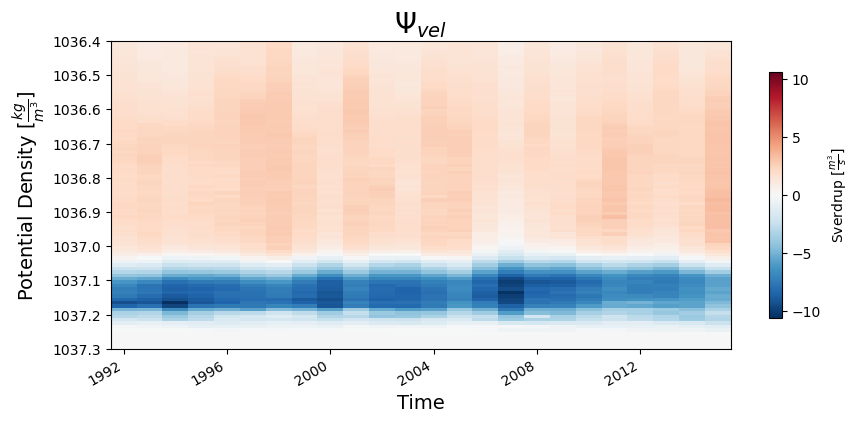

In [91]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4), yincrease=False,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20)
plt.ylim(1037.3, 1036.4);

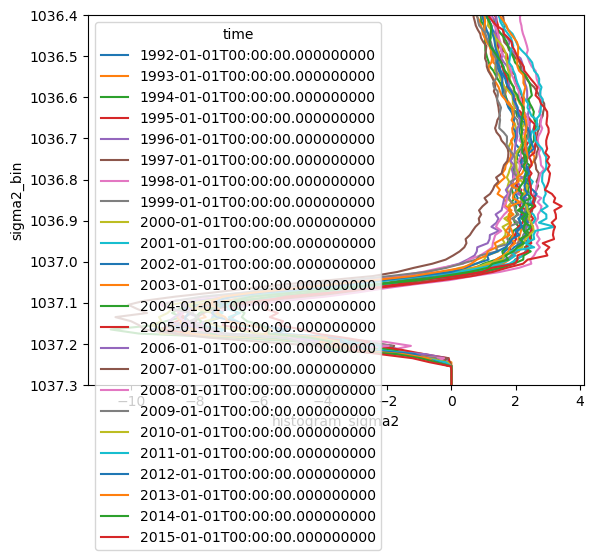

In [92]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot.line(y='sigma2_bin')#, add_legend=False)
plt.ylim(1037.3, 1036.4);

## R2 = $\Psi_{adv} - \Psi_{vel}$ (Numerical Mixing)

In [93]:
R2 = (psi_adv - psi_vel).load()
R2_th = (psi_adv_th - psi_vel).load()
R2_slt = (psi_adv_slt - psi_vel).load()

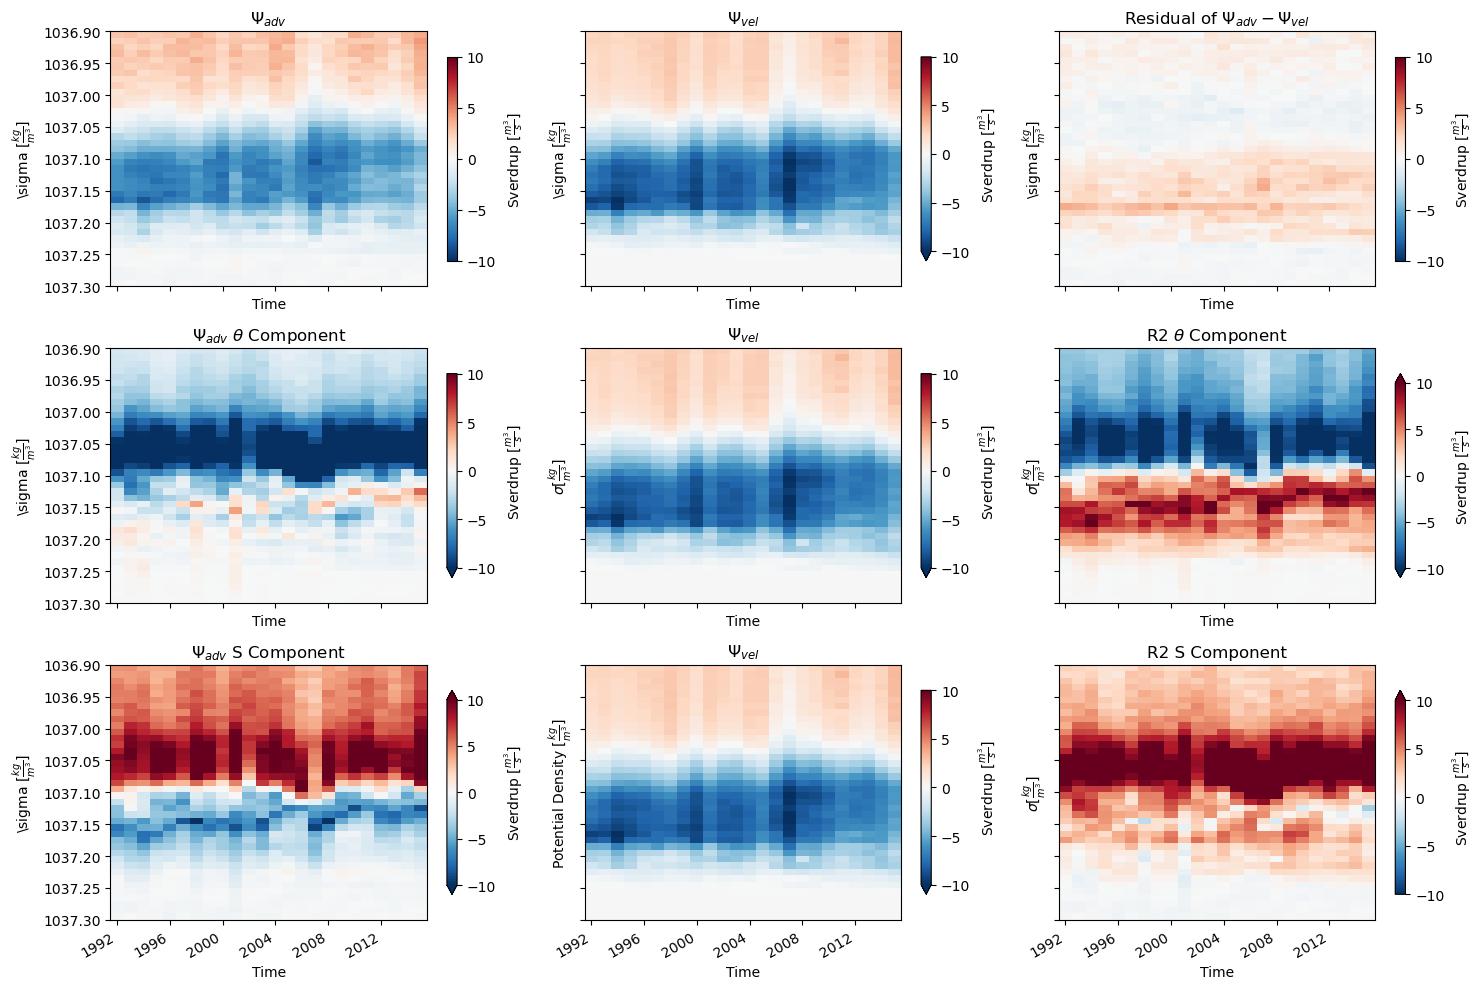

In [94]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharey=True, sharex=True)

(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,0], vmax=10, yincrease=False,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,0].set_xlabel('Time')
axes[0,0].set_title(r'$\Psi_{adv}$')
#axes[0,0].set_ylim(1037.3, 1036.4)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,1], vmax=10,  yincrease=False,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,1].set_xlabel('Time')
axes[0,1].set_title('$\Psi_{vel}$')
#axes[0,1].set_ylim(1037.3, 1036.4)

(R2/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,2], vmax=10,  yincrease=False,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,2].set_xlabel('Time')
axes[0,2].set_title(r'Residual of $\Psi_{adv} - \Psi_{vel}$')
#axes[0,2].set_ylim(1037.3, 1036.4)

(psi_adv_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,0], vmax=10, yincrease=False,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,0].set_xlabel('Time')
axes[1,0].set_title(r'$\Psi_{adv}$ $\theta$ Component')
#axes[1,0].set_ylim(1037.3, 1036.4)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,1], vmax=10,  yincrease=False,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,1].set_xlabel('Time')
axes[1,1].set_title('$\Psi_{vel}$')
#axes[1,1].set_ylim(1037.3, 1036.4)

(R2_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,2], vmax=10,  yincrease=False,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,2].set_xlabel('Time')
axes[1,2].set_title(r'R2 $\theta$ Component')
#axes[1,2].set_ylim(1037.3, 1036.4)

(psi_adv_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,0], vmax=10, yincrease=False,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,0].set_xlabel('Time')
axes[2,0].set_title(r'$\Psi_{adv}$ S Component')
#axes[2,0].set_ylim(1037.3, 1036.4)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,1], vmax=10,  yincrease=False,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,1].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$')
axes[2,1].set_xlabel('Time')
axes[2,1].set_title('$\Psi_{vel}$')
#axes[2,1].set_ylim(1037.3, 1036.4)

(R2_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,2], vmax=10,  yincrease=False,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,2].set_xlabel('Time')
axes[2,2].set_title(r'R2 S Component')
axes[2,2].set_ylim(1037.3, 1036.9)

plt.tight_layout();

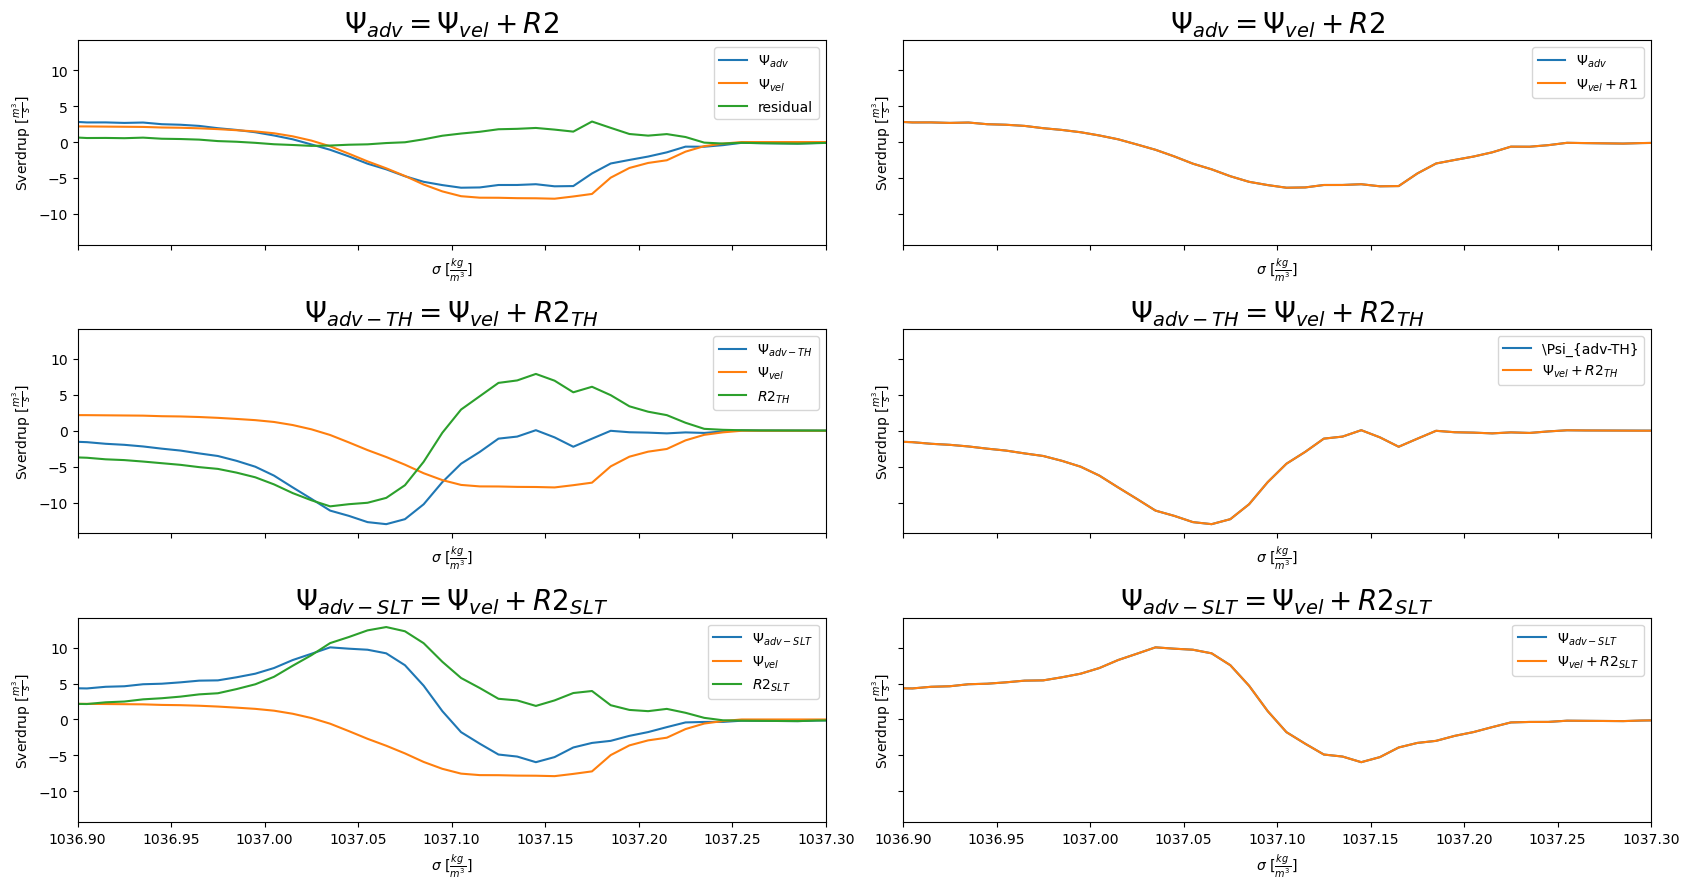

In [95]:
fig, axes = plt.subplots(3, 2, figsize=(17, 9), sharey=True, sharex=True)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=axes[0,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[0,0])
(R2/1e6).mean(dim='time').plot(label='residual', ax=axes[0,0])
axes[0,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[0,0].legend()
axes[0,0].set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)
#axes[0,0].set_xlim(1036.4, 1037.3)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=axes[0,1])
((psi_vel + R2)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R1$', ax=axes[0,1])
axes[0,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[0,1].legend()
axes[0,1].set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)
#axes[0,1].set_xlim(1036.4, 1037.3)

(psi_adv_th/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-TH}$', ax=axes[1,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[1,0])
(R2_th/1e6).mean(dim='time').plot(label=r'$R2_{TH}$', ax=axes[1,0])
axes[1,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[1,0].legend()
axes[1,0].set_title(r'$\Psi_{adv-TH} = \Psi_{vel} + R2_{TH}$ ', fontsize=20)
#axes[1,0].set_xlim(1036.4, 1037.3)

(psi_adv_th/1e6).mean(dim='time').plot(label='\Psi_{adv-TH}', ax=axes[1,1])
((psi_vel + R2_th)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R2_{TH}$', ax=axes[1,1])
axes[1,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[1,1].legend()
axes[1,1].set_title(r'$\Psi_{adv-TH} = \Psi_{vel} + R2_{TH}$', fontsize=20)
#axes[1,1].set_xlim(1036.4, 1037.3)

(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-SLT}$', ax=axes[2,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[2,0])
(R2_slt/1e6).mean(dim='time').plot(label=r'$R2_{SLT}$', ax=axes[2,0])
axes[2,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[2,0].legend()
axes[2,0].set_title(r'$\Psi_{adv-SLT} = \Psi_{vel} + R2_{SLT}$', fontsize=20)
#axes[2,0].set_xlim(1036.4, 1037.3)

(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-SLT}$', ax=axes[2,1])
((psi_vel + R2_slt)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R2_{SLT}$', ax=axes[2,1])
axes[2,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[2,1].legend()
axes[2,1].set_title(r'$\Psi_{adv-SLT} = \Psi_{vel} + R2_{SLT}$', fontsize=20)
axes[2,1].set_xlim(1036.9, 1037.3)

plt.tight_layout();

# <font color='Green'>\begin{equation*} \Omega_{tottend-truth} = \Psi_{adv} + \Omega_{trans-rate} + R3 \end{equation*} </font>

In [96]:
psi_vel.coords

Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

In [97]:
dVdt.coords

Coordinates:
    time_snp    (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [99]:
omega_trans_rate.coords

Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [100]:
omega_total = omega_total[1:-1]
omega_total_th = omega_total_th[1:-1]
omega_total_slt = omega_total_slt[1:-1]
omega_trans_rate = omega_trans_rate[1:-1]
omega_trans_rate_th = omega_trans_rate_th[1:-1]
omega_trans_rate_slt = omega_trans_rate_slt[1:-1]
psi_adv = psi_adv[1:-1]
psi_adv_th = psi_adv_th[1:-1]
psi_adv_th = psi_adv_th[1:-1]
psi_vel = psi_vel[1:-1]
R2 = R2[1:-1]

In [101]:
R3_th = omega_total_th - (psi_adv_th + omega_trans_rate_th)
R3_th.load()
R3_slt = omega_total_slt - (psi_adv_slt + omega_trans_rate_slt)
R3_slt.load()
R3 = omega_total - (psi_adv + omega_trans_rate)
R3.load()

<xarray.DataArray (time: 286, sigma2_bin: 999)>
array([[    0.        ,     0.        ,     0.        , ...,
         -373.77957258,  -382.63512939,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
        -1099.47416464,  -229.93008142,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
          465.8148028 ,  2734.43777781,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])
Coordinates:
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

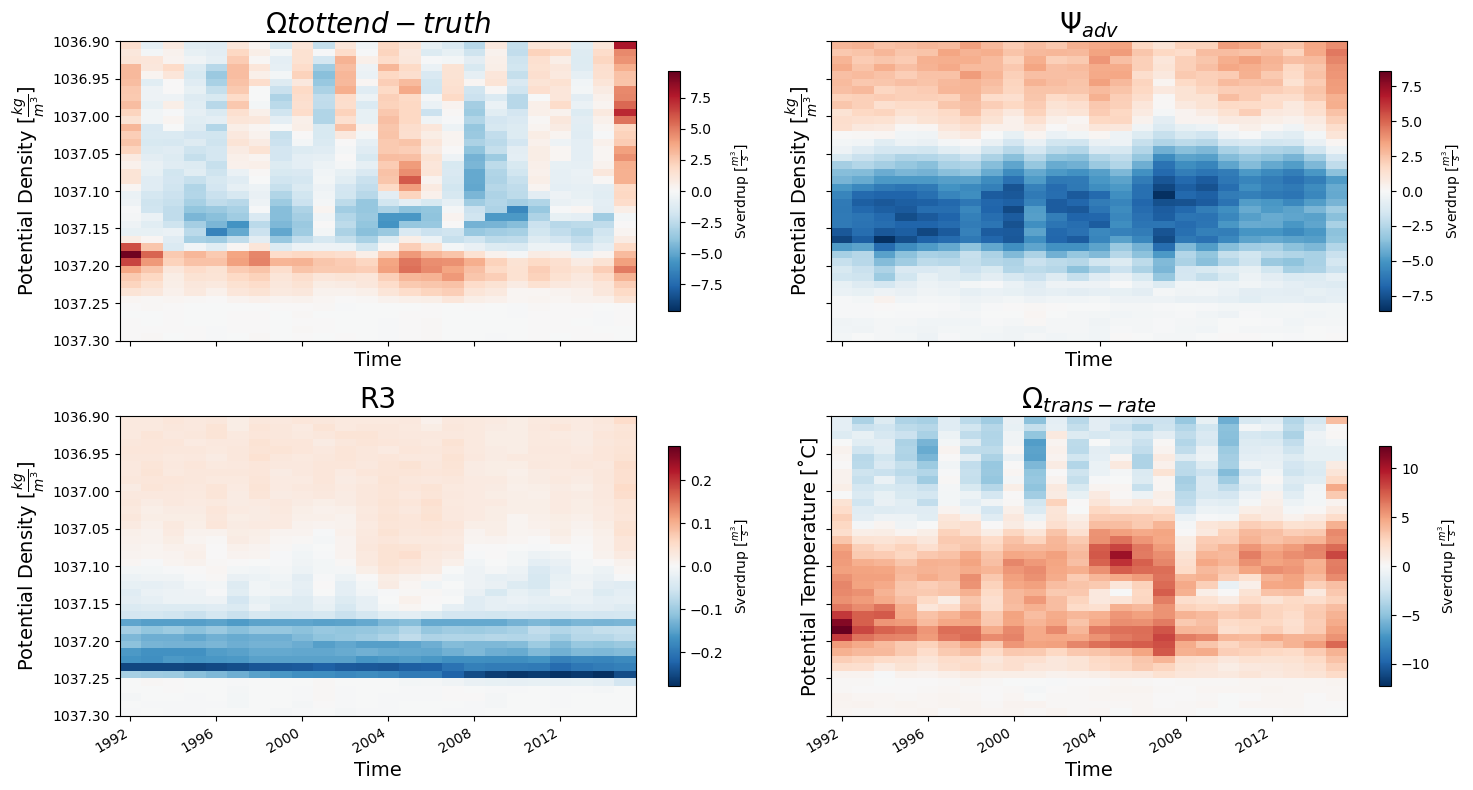

In [102]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8), sharey=True, sharex=True)

(omega_total/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[0,0], yincrease=False,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[0,0].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\Omega{tottend-truth}$', fontsize=20)
#ax[0,0].set_ylim(1036.4, 1037.3)

(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[0,1], yincrease=False, 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[0,1].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title('$\Psi_{adv}$', fontsize=20)
#ax[0,1].set_ylim(1036.4, 1037.3)

(R3/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[1,0], yincrease=False, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[1,0].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title(r'R3', fontsize=20)
#ax[1,0].set_ylim(1036.4, 1037.3)

(omega_trans_rate/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[1,1], yincrease=False, 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[1,1].set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title('$\Omega_{trans-rate}$', fontsize=20)
ax[1,1].set_ylim(1037.3, 1036.9)

plt.tight_layout();

(1036.9, 1037.3)

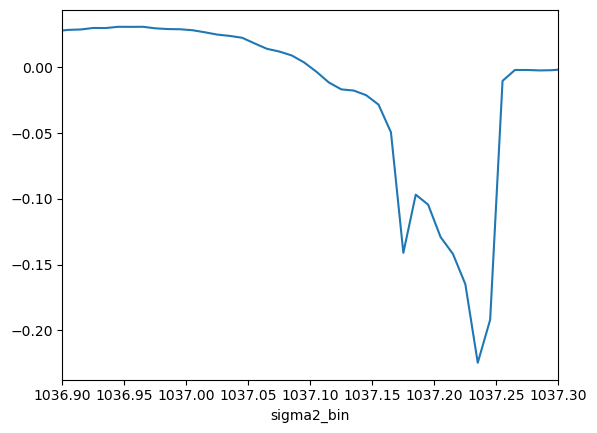

In [103]:
(R3/1e6).mean(dim='time').plot()
plt.xlim(1036.9, 1037.3)

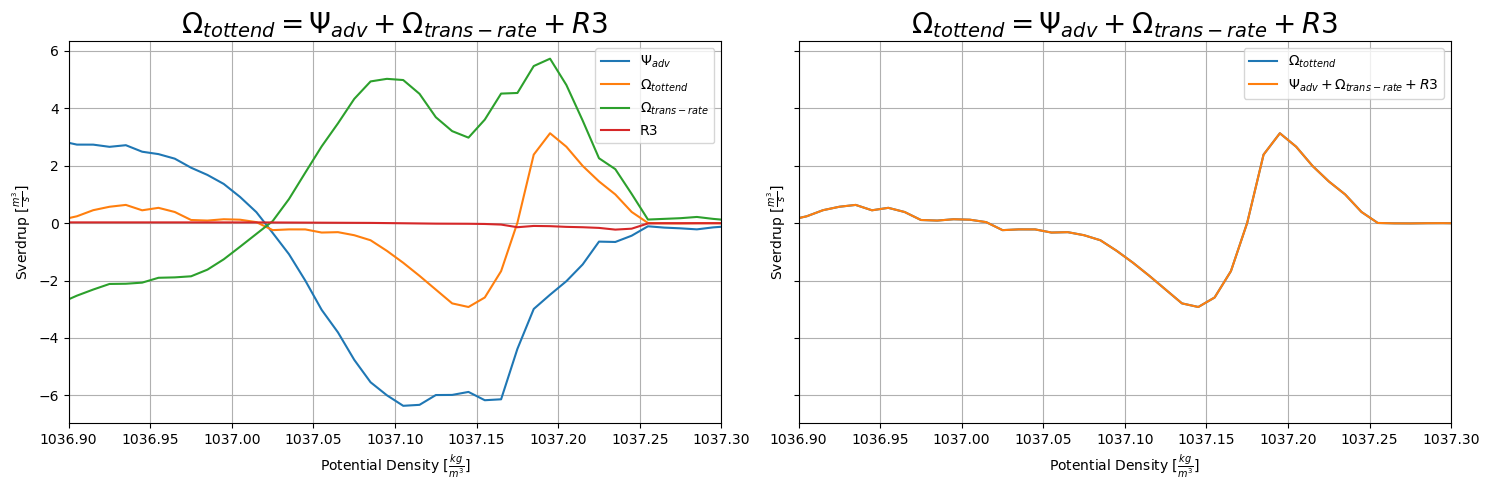

In [104]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=ax0)
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax0)
(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega_{trans-rate}$', ax=ax0)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel(r'Potential Density $[\frac{kg}{m^3}]$')
ax0.legend()
ax0.grid()
ax0.set_title(r'$\Omega_{tottend} = \Psi_{adv} + \Omega_{trans-rate} + R3$', fontsize=20)
#ax0.set_xlim(1036.4, 1037.3)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax1)
((psi_adv + omega_trans_rate + R3)/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}+\Omega_{trans-rate}+R3$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel(r'Potential Density $[\frac{kg}{m^3}]$')
ax1.legend()
ax1.grid()
ax1.set_title(r'$\Omega_{tottend} = \Psi_{adv} + \Omega_{trans-rate} + R3$', fontsize=20)
ax1.set_xlim(1036.9, 1037.3)

plt.tight_layout();

(1037.5, 1036.5)

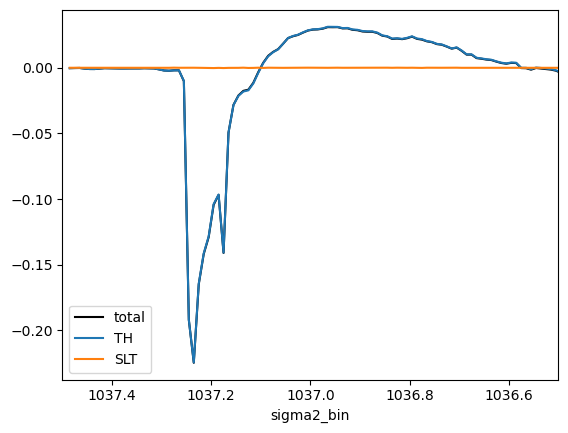

In [105]:
(R3/1e6).mean(dim='time').plot(color='k', label='total')
(R3_th/1e6).mean(dim='time').plot(label='TH')
(R3_slt/1e6).mean(dim='time').plot(label='SLT')
plt.legend()
plt.xlim(1037.5, 1036.5)

(1036.9, 1037.3)

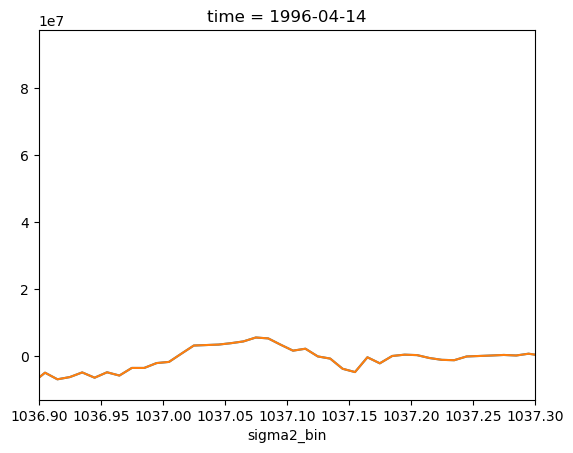

In [106]:
n = 50
omega_total.isel(time=n).plot()
(omega_trans_rate + psi_adv + R3).isel(time=n).plot()
plt.xlim(1036.9, 1037.3)

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} = \Psi_{vel} + R2 + \Omega_{trans-rate} + R3 + R1 \end{equation*} </font>

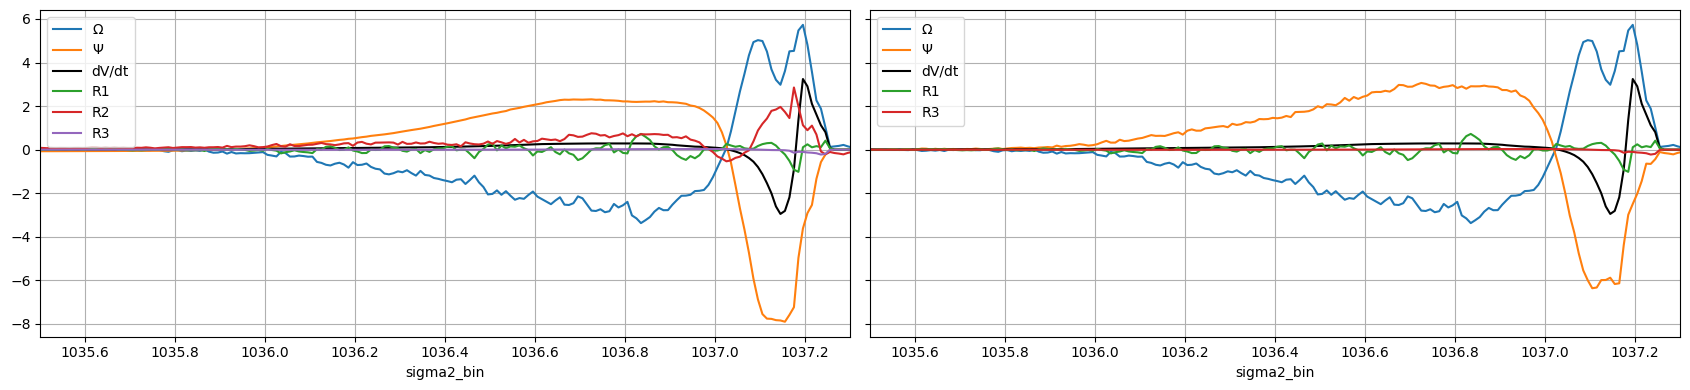

In [107]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(17, 4), sharey=True, sharex=True)

(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', ax=ax0)
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', ax=ax0)
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax0)
(R1/1e6).mean(dim='time').plot(label='R1', ax=ax0)
(R2/1e6).mean(dim='time').plot(label='R2', ax=ax0)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax0)
ax0.legend()
ax0.grid()
#ax0.set_xlim(1036.4, 1037.3)

(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', ax=ax1)
(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi$', ax=ax1)
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax1)
(R1/1e6).mean(dim='time').plot(label='R1', ax=ax1)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax1)
ax1.legend()
ax1.grid()
ax1.set_xlim(1035.5, 1037.3)
plt.tight_layout();

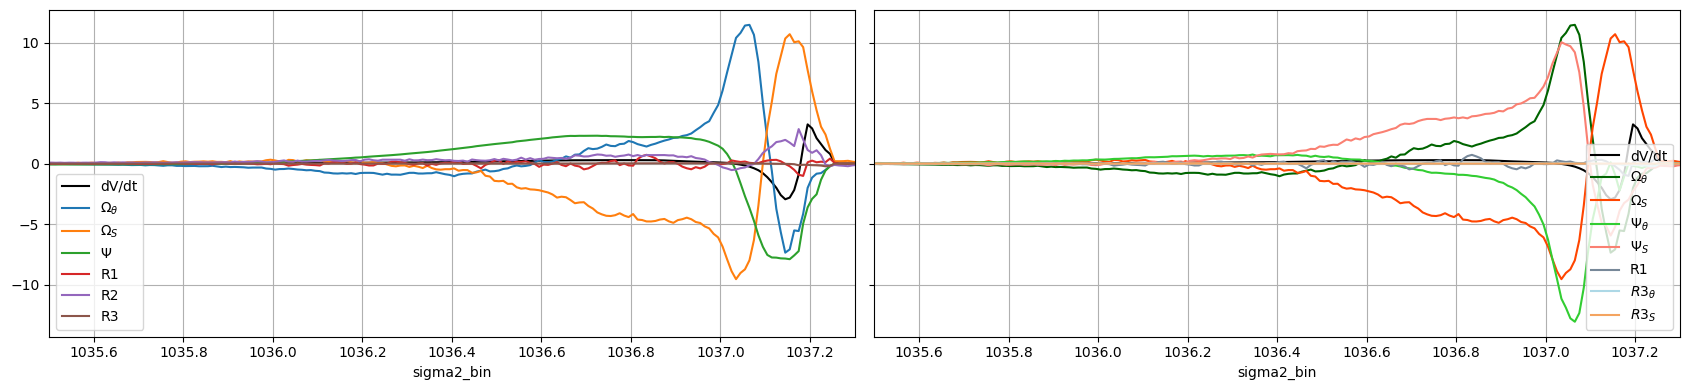

In [108]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(17, 4), sharey=True, sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax0)
(omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', ax=ax0)
(omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', ax=ax0)
(psi_vel[1:-1]/1e6).mean(dim='time').plot(label=r'$\Psi$', ax=ax0)

(R1/1e6).mean(dim='time').plot(label='R1', ax=ax0)
(R2/1e6).mean(dim='time').plot(label='R2', ax=ax0)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax0)
ax0.legend()
ax0.grid()
#ax0.set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax1)
(omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', ax=ax1, color='darkgreen')
(omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', ax=ax1, color='orangered')
(psi_adv_th/1e6).mean(dim='time').plot(label=r'$\Psi_{\theta}$', ax=ax1, color='limegreen')
(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_S$', ax=ax1, color='salmon')
(R1/1e6).mean(dim='time').plot(label='R1', ax=ax1, color='lightslategray')
(R3_th/1e6).mean(dim='time').plot(label=r'$R3_{\theta}$', ax=ax1, color='lightblue')
(R3_slt/1e6).mean(dim='time').plot(label=r'$R3_S$', ax=ax1, color='sandybrown')
ax1.legend()
ax1.grid()
ax1.set_xlim(1035.5, 1037.3)
plt.tight_layout();

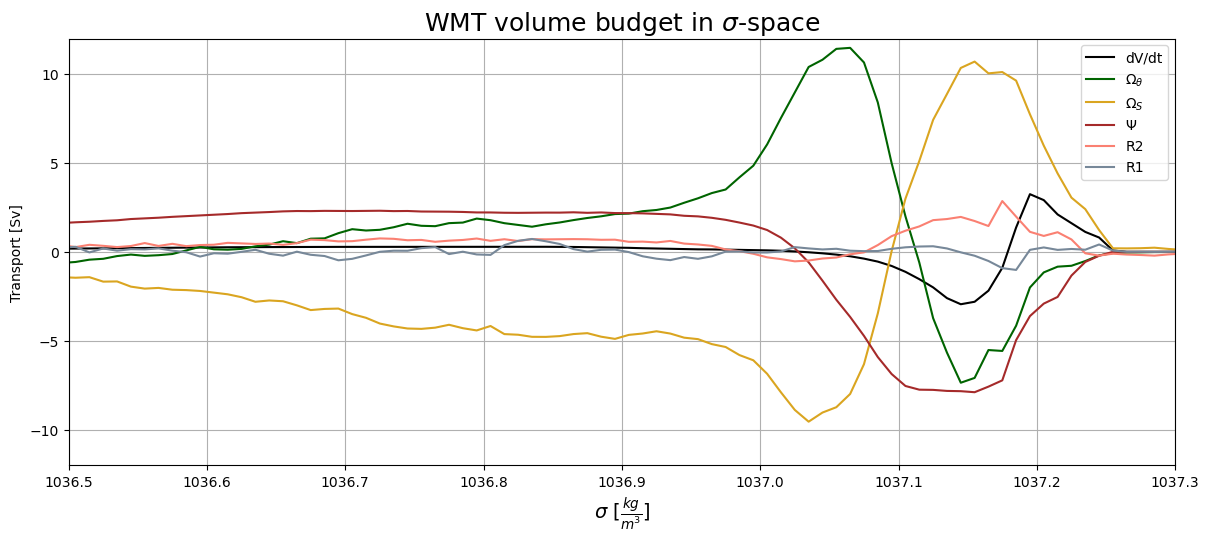

In [109]:
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='darkgreen')
(omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod')
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.ylim(-12, 12)
plt.xlim(1036.5, 1037.3)
plt.tight_layout()
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget in $\sigma$-space', fontsize=18);

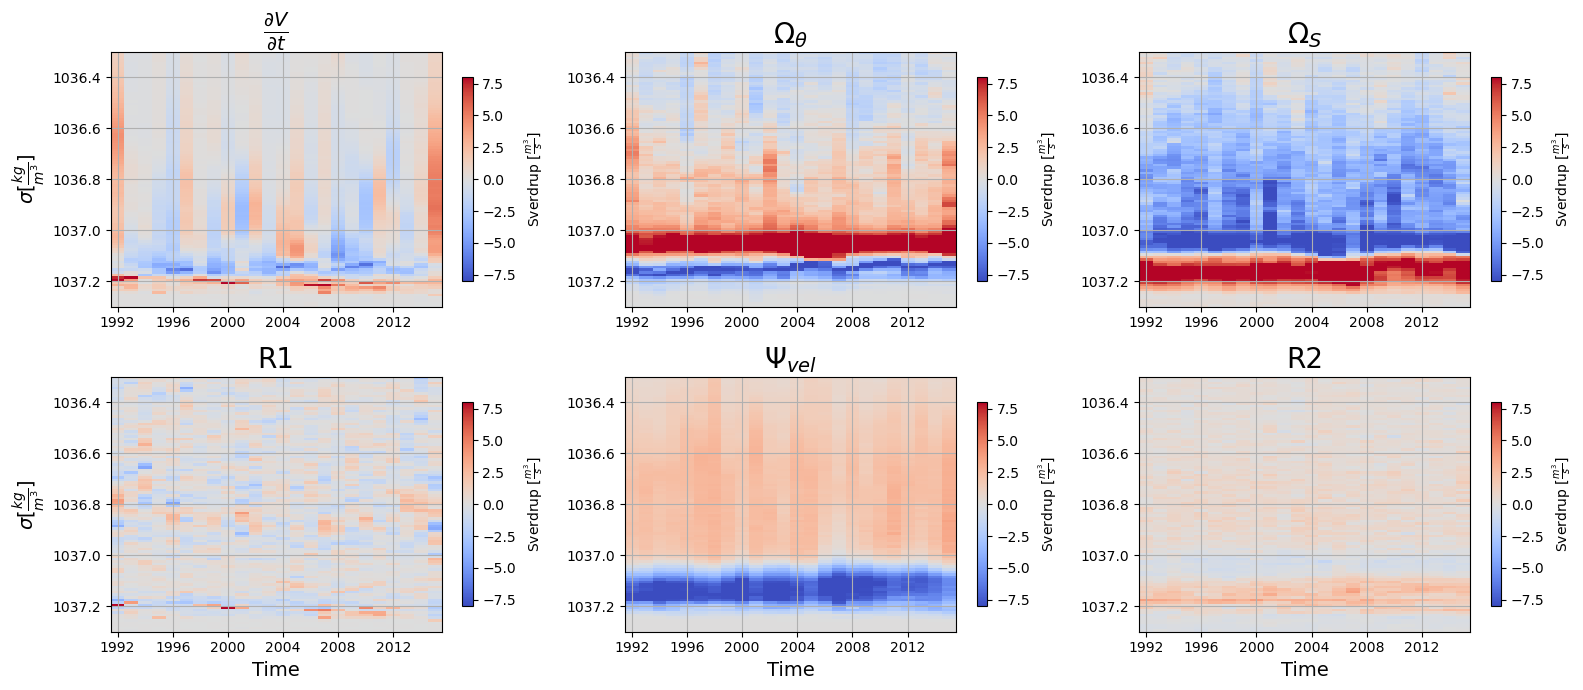

In [110]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7))#, sharex=True)

dVdt_resampled = dVdt.resample(time='AS').mean(dim='time') / 1e6
c = ax[0,0].pcolormesh(dVdt_resampled.time, 
                   dVdt_resampled.sigma2_bin, 
                   dVdt_resampled.T, vmin=-8, vmax=8, cmap='coolwarm')
plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax[0,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax[0,0].set_ylim(1037.3, 1036.3)
ax[0,0].grid()

omega_th_resampled = (omega_trans_rate_th/1e6).resample(time='AS').mean(dim='time')
c0 = ax[0,1].pcolormesh(omega_th_resampled.time, omega_th_resampled.sigma2_bin, omega_th_resampled.T,
                        cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c0, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,1])
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title(r'$\Omega_{\theta}$', fontsize=20)
ax[0,1].set_ylim(1037.3, 1036.3)
ax[0,1].grid()

omega_slt_resampled = (omega_trans_rate_slt/1e6).resample(time='AS').mean(dim='time')
c1 = ax[0,2].pcolormesh(omega_slt_resampled.time, omega_slt_resampled.sigma2_bin, omega_slt_resampled.T,
                        cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c1, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,2])
#ax[0,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,2].set_xlabel('Time', fontsize=14)
ax[0,2].set_title(r'$\Omega_{S}$', fontsize=20)
ax[0,2].set_ylim(1037.3, 1036.3)
ax[0,2].grid()

R1_resampled = (R1/1e6).resample(time='AS').mean(dim='time')
c2 = ax[1,0].pcolormesh(R1_resampled.time, R1_resampled.sigma2_bin, R1_resampled.T,
                             cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c2, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,0])
ax[1,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title('R1', fontsize=20)
ax[1,0].set_ylim(1037.3, 1036.3)
ax[1,0].grid()

psi_vel_resampled = (psi_vel/1e6).resample(time='AS').mean(dim='time')
c3 = ax[1,1].pcolormesh(psi_vel_resampled.time, psi_vel_resampled.sigma2_bin, psi_vel_resampled.T,
                        cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c3, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title(r'$\Psi_{vel}$', fontsize=20)
ax[1,1].set_ylim(1037.3, 1036.3)
ax[1,1].grid()

R2_resampled = (R2/1e6).resample(time='AS').mean(dim='time')
c4 = ax[1,2].pcolormesh(R2_resampled.time, R2_resampled.sigma2_bin, R2_resampled.T,
                             cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c4, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,2])
#ax[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,2].set_xlabel('Time', fontsize=14)
ax[1,2].set_title('R2', fontsize=20)
ax[1,2].set_ylim(1037.3, 1036.3)
ax[1,2].grid()
plt.tight_layout();

In [111]:
dVdt_resampled.time

<xarray.DataArray 'time' (time: 24)>
array(['1992-01-01T00:00:00.000000000', '1993-01-01T00:00:00.000000000',
       '1994-01-01T00:00:00.000000000', '1995-01-01T00:00:00.000000000',
       '1996-01-01T00:00:00.000000000', '1997-01-01T00:00:00.000000000',
       '1998-01-01T00:00:00.000000000', '1999-01-01T00:00:00.000000000',
       '2000-01-01T00:00:00.000000000', '2001-01-01T00:00:00.000000000',
       '2002-01-01T00:00:00.000000000', '2003-01-01T00:00:00.000000000',
       '2004-01-01T00:00:00.000000000', '2005-01-01T00:00:00.000000000',
       '2006-01-01T00:00:00.000000000', '2007-01-01T00:00:00.000000000',
       '2008-01-01T00:00:00.000000000', '2009-01-01T00:00:00.000000000',
       '2010-01-01T00:00:00.000000000', '2011-01-01T00:00:00.000000000',
       '2012-01-01T00:00:00.000000000', '2013-01-01T00:00:00.000000000',
       '2014-01-01T00:00:00.000000000', '2015-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1993-01-01 ... 2015-01-01

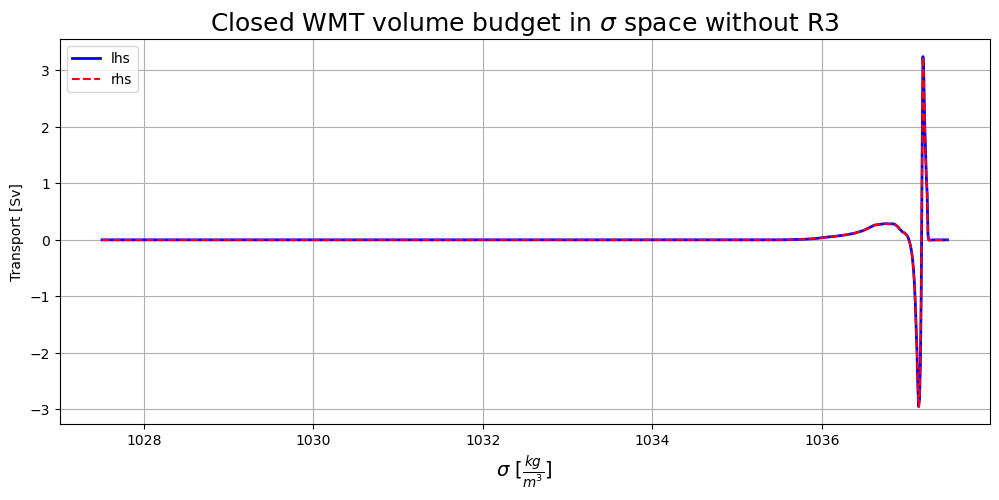

In [113]:
(dVdt/1e6).mean(dim='time').plot(label='lhs', color='blue', linewidth=2, figsize=(12,5)) 
((omega_trans_rate + psi_adv + R1 + R3)/1e6).mean(dim='time').plot(color='red', linestyle='dashed', label='rhs')
#plt.title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega + \Psi + R3 + R1$', fontsize=18)
plt.title(r'Closed WMT volume budget in $\sigma$ space without R3', fontsize=18)
plt.legend()
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.grid()
#plt.ylim(-2.0,4.0)
#plt.xlim(1036.9, 1037.27);

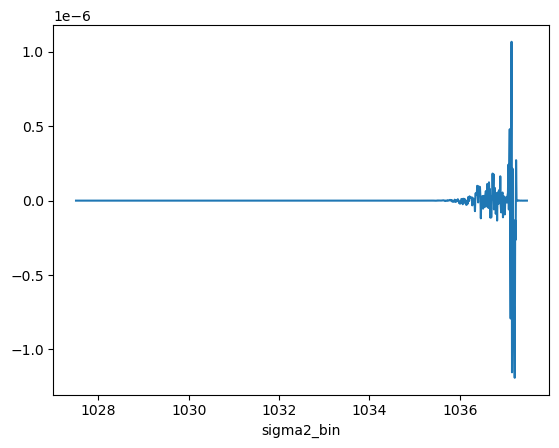

In [114]:
((dVdt/1e6).mean(dim='time') - ((omega_trans_rate + psi_adv + R1 + R3)/1e6).mean(dim='time')).plot()

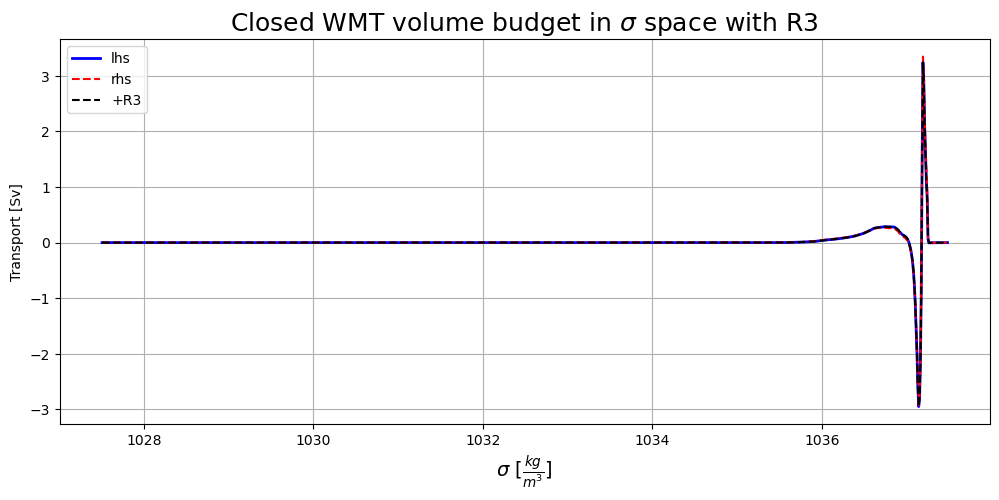

In [115]:
(dVdt/1e6).mean(dim='time').plot(label='lhs', color='blue', linewidth=2, figsize=(12,5)) 
((omega_trans_rate + psi_adv + R1)/1e6).mean(dim='time').plot(color='red', linestyle='dashed', label='rhs')
((omega_trans_rate + psi_adv + R1 +R3)/1e6).mean(dim='time').plot(color='k', linestyle='dashed', label='+R3')
#plt.title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega + \Psi + R3 + R1$', fontsize=18)
plt.title(r'Closed WMT volume budget in $\sigma$ space with R3', fontsize=18)
plt.legend()
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.grid()
#plt.ylim(-2.0,4.0)
##plt.xlim(1036.9, 1037.27);

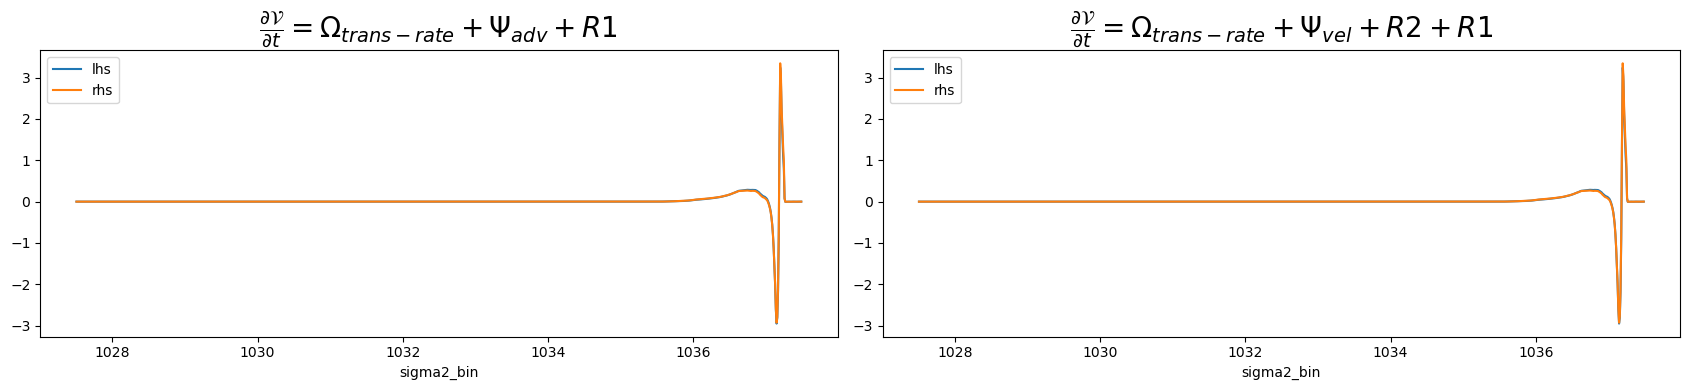

In [116]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(17,4))

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax0) 
((omega_trans_rate + psi_adv + R1)/1e6).mean(dim='time').plot(label='rhs', ax=ax0)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{adv} + R1$', fontsize=20, fontweight='bold')
ax0.legend()
#ax0.set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax1) 
((omega_trans_rate + R1 + psi_vel + R2)/1e6).mean(dim='time').plot(label='rhs', ax=ax1)
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{vel} + R2 + R1$', fontsize=20, fontweight='bold')
ax1.legend()
#ax1.set_xlim(1036.4, 1037.3)

plt.tight_layout();

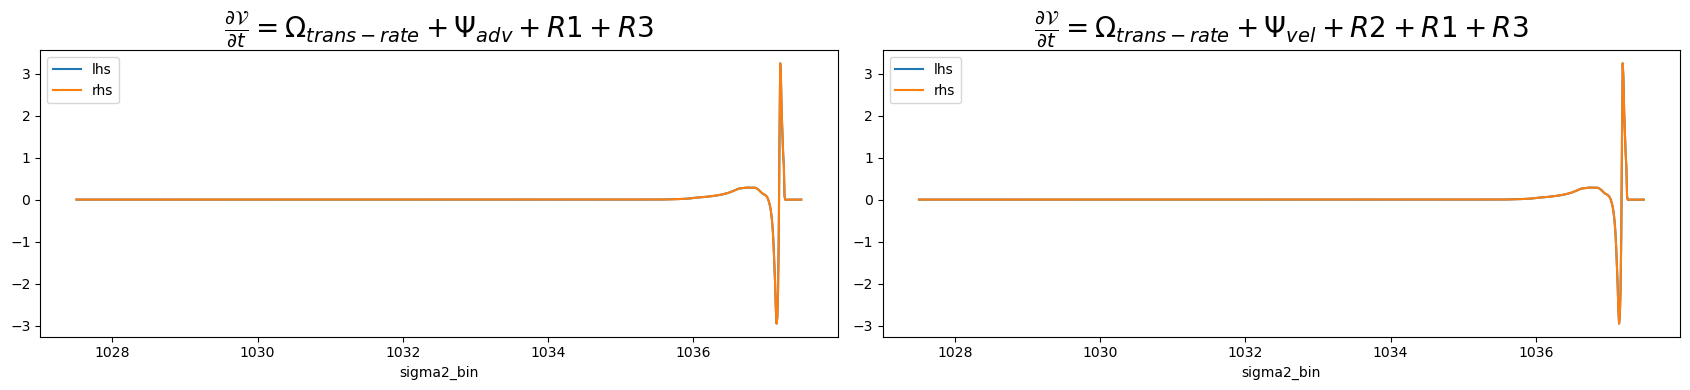

In [117]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(17,4))

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax0) 
((omega_trans_rate + psi_adv + R1+R3)/1e6).mean(dim='time').plot(label='rhs', ax=ax0)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{adv} + R1 + R3$', fontsize=20, fontweight='bold')
ax0.legend()
#ax0.set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax1) 
((omega_trans_rate + R1 + psi_vel + R2+R3)/1e6).mean(dim='time').plot(label='rhs', ax=ax1)
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{vel} + R2 + R1 + R3$', fontsize=20, fontweight='bold')
ax1.legend()
#ax1.set_xlim(1036.4, 1037.3)

plt.tight_layout();

## Breaking up $\Omega_{trans-rate}$ term

In [118]:
omega_mix_th = (all_dsets_th.OMEGA_conv_horiz_diff_flux_TH + 
                  all_dsets_th.OMEGA_conv_vert_diff_flux_TH).load()
omega_mix_slt = (all_dsets_slt.OMEGA_conv_diff_flux_SLT).load()
omega_surf_th = (all_dsets_th.OMEGA_sw_flux_conv_TH + 
                  all_dsets_th.OMEGA_surface_flux_conv_TH).load()
omega_surf_slt = (all_dsets_slt.OMEGA_surface_flux_SLT).load()

omega_surf = (omega_surf_th + omega_surf_slt).load()
omega_mix = (omega_mix_th + omega_mix_slt).load()

## Saving WMT budget terms to GCS zarr

In [119]:
omega_mix[1:-1].coords

Coordinates:
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [120]:
psi_adv.coords

Coordinates:
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [121]:
omega_total.coords

Coordinates:
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [266]:
wmt_budget_terms = xr.merge([dVdt.rename('dVdt'), R1.rename('R1'), 
                             omega_total.rename('omega_total'),
                             omega_total_th.rename('omega_total_th'),
                             omega_total_slt.rename('omega_total_slt'),
                             psi_adv.rename('psi_adv'),
                             psi_adv_th.rename('psi_adv_th'),
                             psi_adv_slt.rename('psi_adv_slt'),
                             psi_vel.rename('psi_vel'), R2.rename('R2'),
                             R2_th.rename('R2_th'), R2_slt.rename('R2_slt'),
                             omega_trans_rate.rename('omega_trans_rate'),
                             omega_trans_rate_th.rename('omega_trans_rate_th'),
                             omega_trans_rate_slt.rename('omega_trans_rate_slt'),
                             omega_surf[1:-1].rename('omega_surf'),
                             omega_surf_slt[1:-1].rename('omega_surf_slt'),
                             omega_surf_th[1:-1].rename('omega_surf_th'), 
                             omega_mix[1:-1].rename('omega_mix'), 
                             omega_mix_th[1:-1].rename('omega_mix_th'),
                             omega_mix_slt[1:-1].rename('omega_mix_slt'),
                             omega_salt_plume[1:-1].rename('omega_slt_plume'),
                             R3.rename('R3'), R3_th.rename('R3_th'), R3_slt.rename('R3_slt')])

In [267]:
wmt_budget_terms

<xarray.Dataset>
Dimensions:               (sigma2_bin: 999, time: 288)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
    time_snp              (time) datetime64[ns] NaT 1992-03-01 ... NaT
Data variables: (12/25)
    dVdt                  (time, sigma2_bin) float32 dask.array<chunksize=(288, 999), meta=np.ndarray>
    R1                    (time, sigma2_bin) float64 dask.array<chunksize=(288, 999), meta=np.ndarray>
    omega_total           (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_total_th        (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_total_slt       (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv               (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    ...                    ...
    omega_mix_th          (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_mix_slt         (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_slt_plume       (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R3                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R3_th                 (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R3_slt                (time, sigma2_bin) float64 nan nan nan ... nan nan nan

In [268]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [269]:
# saving wmt budget terms to gcs
gcsmap_wmt_budget_terms = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/ECCO/wmt_budget_terms.zarr')
wmt_budget_terms.to_zarr(gcsmap_wmt_budget_terms, mode='w')

## Trying to locate HSSW

In [288]:
hssw_location = (sigma2 > 1037.25).astype(int).mean('time') * vol

In [289]:
hssw_location

<xarray.DataArray (k: 50, j: 50, i: 95)>
dask.array<mul, shape=(50, 50, 95), dtype=float64, chunksize=(50, 50, 95), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: j, i

In [296]:
hssw_j_cross_sec_view = hssw_location.mean(dim='i').load()
hssw_i_cross_sec_view = hssw_location.mean(dim='j').load()

In [291]:
hssw_j_cross_sec_view

<xarray.DataArray (k: 50, j: 50)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.43680069e+09, 5.66175332e+09, 7.25200258e+09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: j

In [292]:
hssw_mask = hssw_location.where((sigma2 < 1037.25).astype(int).mean(['time']))
hssw_mask_j_cross_sec_view = hssw_mask.mean(dim='i').load()
hssw_mask_i_cross_sec_view = hssw_mask.mean(dim='j').load()

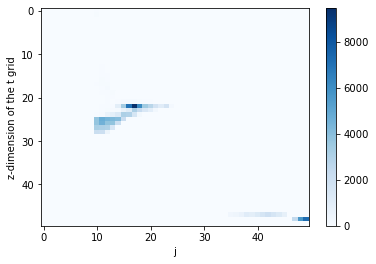

In [294]:
(hssw_j_cross_sec_view/1e6).plot(yincrease=False, cmap='Blues')

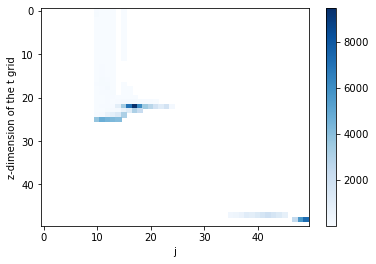

In [297]:
(hssw_j_cross_sec_view.where(hssw_mask_j_cross_sec_view)/1e6).plot(yincrease=False, cmap='Blues')

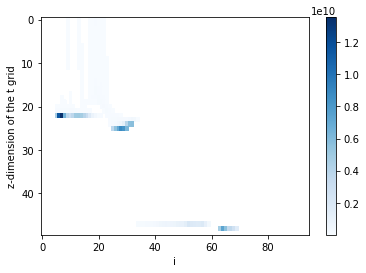

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1296, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/noteboo

In [298]:
hssw_i_cross_sec_view.where(hssw_mask_i_cross_sec_view).plot(yincrease=False, cmap='Blues')

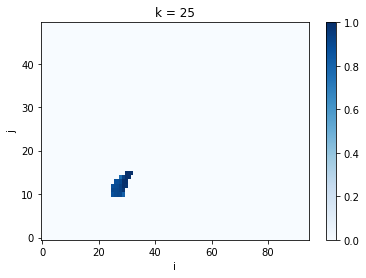

In [287]:
hssw_location[25].plot(cmap='Blues')

In [266]:
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

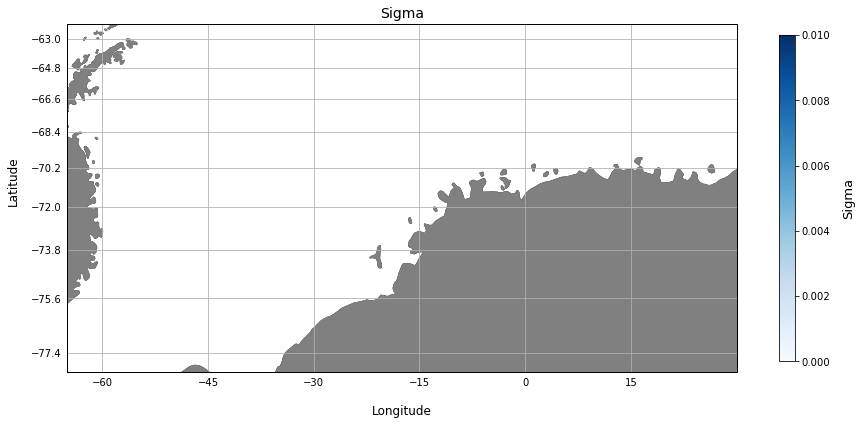

In [276]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(hssw_location.i, 
                   hssw_location.j, 
                   hssw_location[22], 
                   transform=ccrs.PlateCarree(), cmap='Blues', vmax=0.01)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Sigma", labelpad=12, fontsize=13)

plt.contourf(hssw_location.i, 
            hssw_location.j, 
            hssw_location[0],
             transform=ccrs.PlateCarree(), colors='none', hatches=['//'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Sigma", fontsize=14);

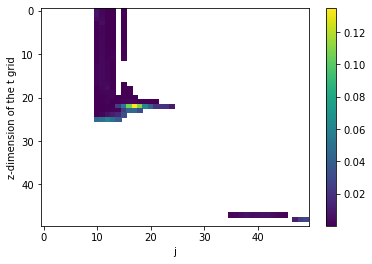

In [259]:
hssw.where(hssw_mask).plot(yincrease=False)

In [218]:
wmt_budget_terms.omega_total

<xarray.DataArray 'omega_total' (time: 288, sigma2_bin: 999)>
array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [    0.        ,     0.        ,     0.        , ...,
        -6845.07302107, -2648.78741706,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
        -9264.73550977,   -55.58460345,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp    (time) datetime64[ns] NaT 1992-03-01 ... 2015-12-01 NaT

In [216]:
wmt_budget_terms.omega_total.mean(dim='time').where(hssw_location)#.plot()

<xarray.DataArray 'omega_total' (sigma2_bin: 999, k: 50, j: 50, i: 95)>
dask.array<where, shape=(999, 50, 50, 95), dtype=float64, chunksize=(999, 50, 50, 95), chunktype=numpy.ndarray>
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03
  * k           (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: j, i

(array([  3176.,    794.,   1588.,   3970., 734450.,  39700.,   5558.,
           794.,   1588.,   1588.]),
 array([-1888482.34596373, -1496110.8388319 , -1103739.33170007,
         -711367.82456824,  -318996.31743641,    73375.18969542,
          465746.69682725,   858118.20395908,  1250489.71109091,
         1642861.21822274,  2035232.72535457]),
 <a list of 10 Patch objects>)

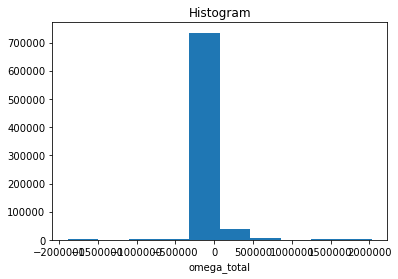

In [215]:
wmt_budget_terms.omega_total.mean(dim='time').where(hssw_location).plot()

### SAM INDEX

In [ ]:
import pandas as pd

In [ ]:
ds_sam = pd.read_csv('/home/jovyan/WMT/Climate-Indices/newsam.1957.2007.seas.txt', delim_whitespace=True, parse_dates=True)

In [ ]:
ds_sam

In [ ]:
ds_sam.ANN.plot()

In [ ]:
sam = xr.Dataset(ds_sam, coords={'time':ds_sam.index.rename('time')})

In [ ]:
sam

In [ ]:
sam = sam.drop('time')

In [ ]:
sam

In [ ]:
sam = sam.swap_dims(dims_dict={'dim_0':'time'})

In [ ]:
sam['time'] = sam.dim_0.rename('time')

In [ ]:
sam

In [ ]:
from scipy.signal import detrend

In [ ]:
sam_ann_detrended = xr.apply_ufunc(detrend, sam.ANN.fillna(0),
                                    kwargs={'axis': 0}).where(~sam.ANN.isnull())

In [ ]:
sam_ann_detrended.plot(figsize=(10,5))
plt.grid()

In [ ]:
sam_ecco_time = sam_ann_detrended.sel(time=slice('1992', '2015'))

In [ ]:
print(sam_ecco_time)

In [ ]:
sam_ecco_time.plot(color='grey', label='SAM')
plt.grid()

In [ ]:
plt.figure(figsize=(12,5))
sam_ecco_time.plot(color='k', label='SAM', linewidth=2)
for dvar in aabw_omega_terms.data_vars:
    (aabw_omega_terms[dvar]/1e6).plot(label=str(dvar))
plt.legend()
plt.ylim(-4,4)
plt.xlim('1993', '2016')
plt.grid()
plt.title('Anomalous AABW transformation \non monthly-time resolution', fontsize=18)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Transport [Sv]')

In [ ]:
plt.figure(figsize=(12,5))
sam_ecco_time.plot(color='k', label='SAM', linewidth=2)
for dvar in cdw_omega_terms.data_vars:
    (cdw_omega_terms[dvar]/1e6).plot(label=str(dvar))
plt.legend()
plt.ylim(-8,8)
plt.xlim('1993', '2016')
plt.grid()
plt.title('Anomalous CDW transformation \non monthly-time resolution', fontsize=18)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Transport [Sv]')

## Timeseries of AABW, CDW, HSSW

In [109]:
aabw_bin = dict(sigma2_bin=1037.199, method='nearest')
cdw_bin = dict(sigma2_bin=1037.118, method='nearest')
hsw_bin = dict(sigma2_bin=1037.357, method='nearest')

In [110]:
wmt_budget_terms = xr.merge([dVdt.rename('dVdt'), omega_trans_rate.rename('omega_trans_rate'), 
                             psi_vel.rename('psi_vel'), R2.rename('R2'), R1.rename('R1')])

In [111]:
wmt_budget_terms = wmt_budget_terms.fillna(0.)

In [112]:
aabw_wmt_budget_terms = wmt_budget_terms.sel(**aabw_bin)

In [113]:
aabw_wmt_budget_terms

<xarray.Dataset>
Dimensions:           (time: 288)
Coordinates:
    sigma2_bin        float64 1.037e+03
  * time              (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp          (time) datetime64[ns] NaT 1992-03-01 ... 2015-12-01 NaT
Data variables:
    dVdt              (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    omega_trans_rate  (time) float64 0.0 -5.139e+05 -5.846e+05 ... 1.47e+06 0.0
    psi_vel           (time) float64 0.0 -4.57e+06 -1.656e+06 ... -1.557e+06 0.0
    R2                (time) float64 -6.141e+05 6.211e+05 ... 2.073e+05
    R1                (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>

In [114]:
aabw_mon_clim = aabw_wmt_budget_terms.groupby('time.month').mean(dim='time')
aabw_anom = aabw_wmt_budget_terms.groupby('time.month') - aabw_mon_clim

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 24 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 24 times more chunks
  return self.array[key]


In [115]:
aabw_anom

<xarray.Dataset>
Dimensions:           (time: 288)
Coordinates:
    sigma2_bin        float64 1.037e+03
  * time              (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp          (time) datetime64[ns] NaT 1992-03-01 ... 2015-12-01 NaT
    month             (time) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12
Data variables:
    dVdt              (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    omega_trans_rate  (time) float64 8.099e+05 -5.472e+04 ... 9.054e+05
    psi_vel           (time) float64 3.804e+06 -1.974e+06 ... 2.701e+06
    R2                (time) float64 -7.229e+05 4.517e+05 ... 1.422e+05
    R1                (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [116]:
aabw_anom_roll = aabw_anom.chunk({'time':6}).rolling(time=12).mean(dim='time')

Text(0.5, 1.0, 'Anomalous AABW on monthly-time resolution')

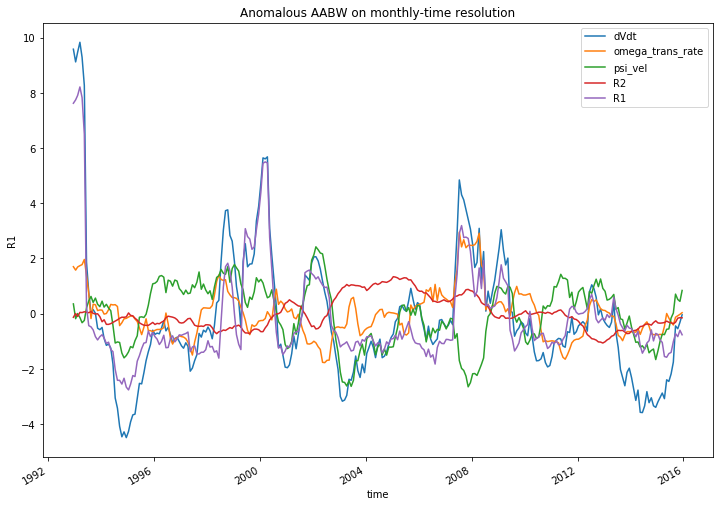

In [117]:
plt.figure(figsize=(12,8))
for dvar in aabw_anom.data_vars:
    (aabw_anom_roll[dvar]/1e6).plot(label=str(dvar))
plt.legend()
#plt.ylim(-15,20)
plt.title('Anomalous AABW on monthly-time resolution')

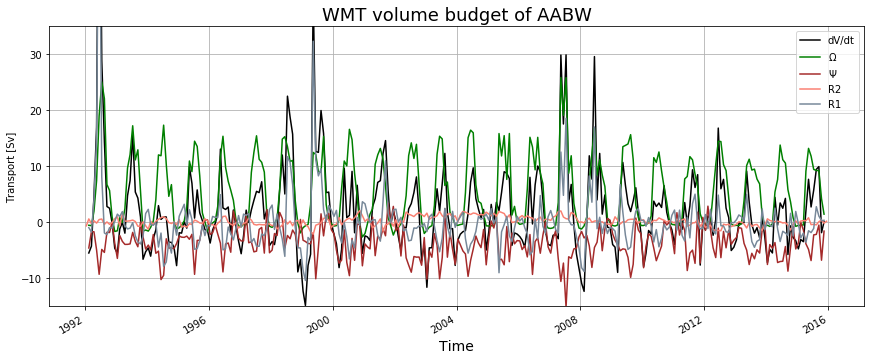

In [118]:
(dVdt/1e6).sel(**aabw_bin).plot(label='dV/dt', color='k', figsize=(12,5))
(omega_trans_rate/1e6).sel(**aabw_bin).plot(label=r'$\Omega$', color='green')
(psi_vel/1e6).sel(**aabw_bin).plot(label=r'$\Psi$', color='brown')
(R2/1e6).sel(**aabw_bin).plot(label='R2', color='salmon')
(R1/1e6).sel(**aabw_bin).plot(label='R1', color='lightslategray')
plt.legend()
plt.grid()
#plt.xlim(1035.5, 1037.5)
plt.ylim(-15, 35)
plt.tight_layout()
plt.xlabel(r'Time', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget of AABW', fontsize=18);

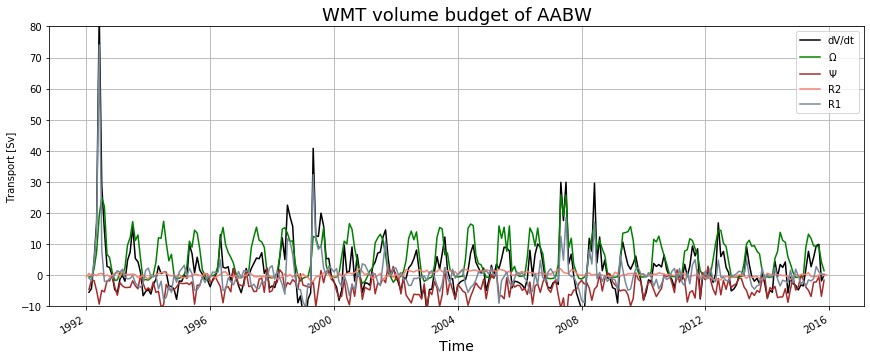

In [119]:
(dVdt/1e6).sel(**aabw_bin).resample(time='MS').mean(dim='time').plot(x='time', label='dV/dt', color='k', figsize=(12,5))
(omega_trans_rate/1e6).sel(**aabw_bin).resample(time='MS').mean(dim='time').plot(x='time', label=r'$\Omega$', color='green')
(psi_vel/1e6).sel(**aabw_bin).resample(time='MS').mean(dim='time').plot(x='time', label=r'$\Psi$', color='brown')
(R2/1e6).sel(**aabw_bin).resample(time='MS').mean(dim='time').plot(x='time', label='R2', color='salmon')
(R1/1e6).sel(**aabw_bin).resample(time='MS').mean(dim='time').plot(x='time', label='R1', color='lightslategray')
plt.legend()
plt.grid()
#plt.xlim(1035.5, 1037.5)
plt.ylim(-10, 80)
plt.tight_layout()
plt.xlabel(r'Time', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget of AABW', fontsize=18);

In [120]:
cdw_wmt_budget_terms = aabw_wmt_budget_terms - wmt_budget_terms.sel(**cdw_bin)

In [121]:
cdw_wmt_budget_terms

<xarray.Dataset>
Dimensions:           (time: 288)
Coordinates:
  * time              (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp          (time) datetime64[ns] NaT 1992-03-01 ... 2015-12-01 NaT
Data variables:
    dVdt              (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    omega_trans_rate  (time) float64 0.0 -9.408e+05 -2.869e+06 ... 2.325e+06 0.0
    psi_vel           (time) float64 0.0 4.177e+06 5.014e+06 ... 3.488e+06 0.0
    R2                (time) float64 1.991e+04 1.196e+06 ... -5.836e+05
    R1                (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>

In [122]:
cdw_mon_clim = cdw_wmt_budget_terms.groupby('time.month').mean(dim='time')
cdw_anom = cdw_wmt_budget_terms.groupby('time.month') - cdw_mon_clim

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 24 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 24 times more chunks
  return self.array[key]


In [123]:
cdw_anom_roll = cdw_anom.chunk({'time':6}).rolling(time=12).mean(dim='time')

Text(0.5, 1.0, 'Anomalous CDW on monthly-time resolution')

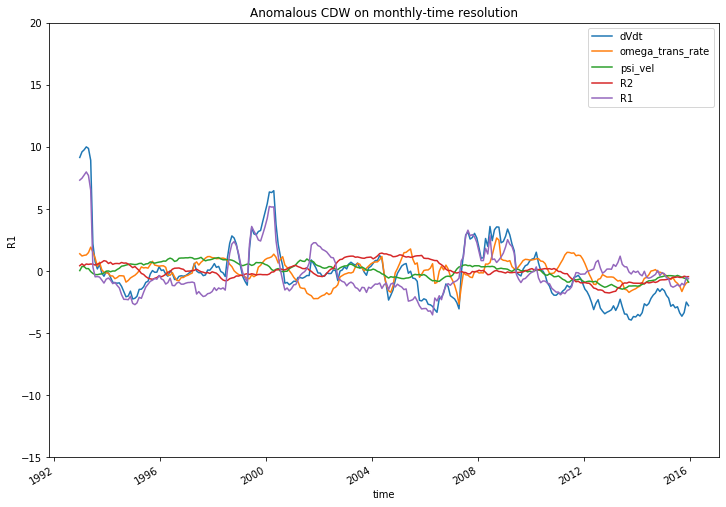

In [124]:
plt.figure(figsize=(12,8))
for dvar in cdw_anom.data_vars:
    (cdw_anom_roll[dvar]/1e6).plot(label=str(dvar))
plt.legend()
plt.ylim(-15,20)
plt.title('Anomalous CDW on monthly-time resolution')

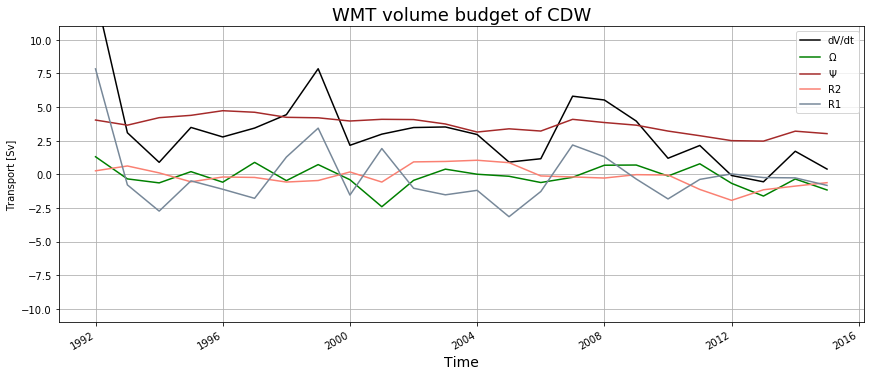

In [125]:
((dVdt.sel(**aabw_bin) - dVdt.sel(**cdw_bin))/1e6).resample(time='AS').mean(dim='time').plot(x='time', 
                                                                                             label='dV/dt', color='k', figsize=(12,5))
((omega_trans_rate.sel(**aabw_bin) - omega_trans_rate.sel(**cdw_bin))/1e6).resample(time='AS').mean(dim='time').plot(x='time', 
                                                                                                                     label=r'$\Omega$', color='green')
((psi_vel/1e6).sel(**aabw_bin) - (psi_vel/1e6).sel(**cdw_bin)).resample(time='AS').mean(dim='time').plot(x='time', 
                                                                                                         label=r'$\Psi$', color='brown')
((R2/1e6).sel(**aabw_bin) - (R2/1e6).sel(**cdw_bin)).resample(time='AS').mean(dim='time').plot(x='time', 
                                                                                               label='R2', color='salmon')
((R1/1e6).sel(**aabw_bin) - (R1/1e6).sel(**cdw_bin)).resample(time='AS').mean(dim='time').plot(x='time', 
                                                                                               label='R1', color='lightslategray')
plt.legend()
plt.grid()
#plt.xlim(1035.5, 1037.5)
plt.ylim(-11, 11)
plt.tight_layout()
plt.xlabel(r'Time', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget of CDW', fontsize=18);

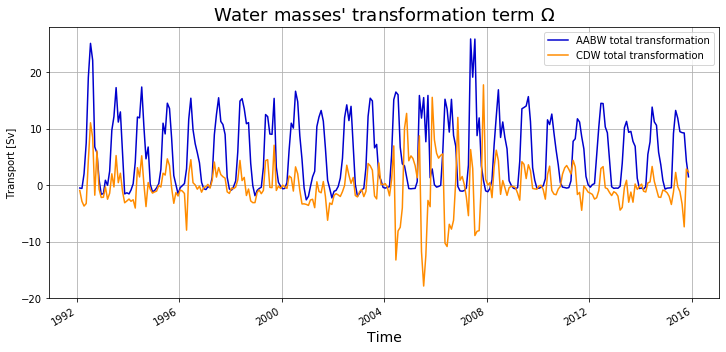

In [126]:
(omega_trans_rate/1e6).sel(**aabw_bin).plot(figsize=(12,5), label='AABW total transformation', color='mediumblue')
((omega_trans_rate/1e6).sel(**aabw_bin) - (omega_trans_rate/1e6)).sel(**cdw_bin).plot(label='CDW total transformation', color='darkorange')
#(omega_trans_rate/1e6).sel(**hsw_bin).plot(label='HSSW total transformation', color='k')
plt.legend()
plt.grid()
#plt.xlim(1035.5, 1037.5)
#plt.ylim(-6, 6)
plt.xlabel(r'Time', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r"Water masses' transformation term $\Omega$", fontsize=18);